In [8]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import random   # Only used for uniform RNG

# Inital data
strikes = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
prices = [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]
risk_free_rate = 0.002
spot = 100

## Black-Scholes price

In [214]:
# Black-Scholes price function
#
# Returns a dictionary containing the price and the greeks of the option
def BS_price(spot, strike, time_to_maturity, r, vol):
    d1 = (np.log(spot / strike) + (r + vol**2 / 2) * (time_to_maturity)) / (vol * np.sqrt(time_to_maturity))
    d2 = d1 - vol * np.sqrt(time_to_maturity)

    price = spot * norm.cdf(d1) - strike * np.exp(-r * time_to_maturity) * norm.cdf(d2)
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (vol * spot * np.sqrt(time_to_maturity))
    vega = spot * np.sqrt(time_to_maturity) * norm.pdf(d1) 
    theta = -spot * norm.pdf(d1) * vol / (2 * np.sqrt(time_to_maturity)) - r * strike * np.exp(-r * time_to_maturity) * norm.cdf(d2) 
    dual_delta = - np.exp(-r * time_to_maturity) * norm.cdf(d2)
    dual_gamma = -np.exp(-r * time_to_maturity) * norm.pdf(d2) / (strike * vol * np.sqrt(time_to_maturity))

    option_parameters = {'price': price, 'delta': delta, 'gamma': gamma, 'vega': vega, 'theta': theta, 'dual delta': dual_delta, 'dual gamma': dual_gamma}

    return option_parameters

# Test:
test_option_par = BS_price(100, 110, 1, 0, 0.2)
print(f'Price: { test_option_par["price"] }') # Should be $4.29
print(f'Delta: { test_option_par["delta"] }') # Should be 0.353
print(f'Gamma: { test_option_par["gamma"] }') # Should be 0.019
print(f'Vega: { test_option_par["vega"] }')   # Should be 37.164
print(f'Theta: { test_option_par["theta"] }')  # Should be -3.716
print(f'Dual Delta: { test_option_par["dual delta"] }') # Should be -0.282
print(f'Dual Gamma: { test_option_par["dual gamma"] }') # Should be -0.015



Price: 4.292010941409885
Delta: 0.35325369152806296
Gamma: 0.018581922182971666
Vega: 37.16384436594333
Theta: -3.7163844365943337
Dual Delta: -0.2821214382854219
Dual Gamma: -0.015356960481794767


## Implied volatility from BS price

In [6]:
# Returns the implied volatility using Newton-Raphson algorithm
def get_implied_vol(spot, strike, time_to_maturity, r, starting_vol, market_price):
    old_vol = 0
    new_vol = starting_vol
    iterations = 1
    while abs(old_vol - new_vol) > 1E-8 and iterations < 1E3 :
        old_vol = new_vol
        opt_parameters = BS_price(spot, strike, time_to_maturity, r, old_vol)
        new_vol = old_vol - (opt_parameters["price"] - market_price) / opt_parameters["vega"]
        iterations += 1
    return new_vol

# Test:
test_implied_vol = get_implied_vol(100, 110, 1, 0.002, 0.2, 6.00)
print(f'Implied volatility: {test_implied_vol}')
test_option_par = BS_price(100, 110, 1, 0.002, test_implied_vol)
print(f'BS price using implied vol: {test_option_par["price"]}   Actual price: 6.00')

Implied volatility: 0.24331750447956413
BS price using implied vol: 6.0   Actual price: 6.00


## Implied volatility smile

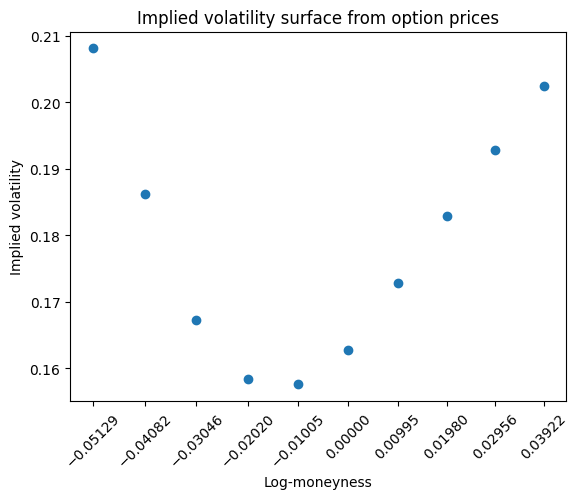

In [27]:
log_moneyness = [np.log(k / spot) for k in strikes]

# Compute the implied volatilities
implied_volatilites = []
for i in range(len(prices)):
    implied_volatilites.append(get_implied_vol(spot, strikes[i], 1, risk_free_rate, 0.2, prices[i]))

# Plot the results
fig, ax = plt.subplots()
ax.set_xlabel("Log-moneyness")
ax.set_ylabel("Implied volatility")
ax.set_title("Implied volatility surface from option prices")
ax.set_xticks(log_moneyness)
ax.tick_params(axis='x', rotation=45)
ax.scatter(log_moneyness, implied_volatilites)
plt.show()

## Estimation of the SVI
#### Definition of the SVI and gSVI formulas

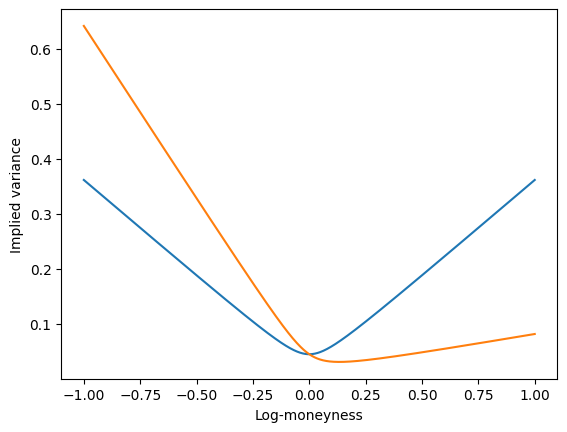

In [8]:
# Definition of the Stochastic Volatility Inspired (SVI) formula
def SVI_func(values, par):
    if isinstance(values, list):
        value = []
        for x in values:
            v = par["a"] + par["b"] * (par["rho"] * (x - par["m"]) + np.sqrt((x - par["m"])**2 + par["sigma"]**2))
            value.append(v)
    else:
        value = par["a"] + par["b"] * (par["rho"] * (values - par["m"]) + np.sqrt((values - par["m"])**2 + par["sigma"]**2))
    return value

# Definition of the generalized Stochastic Volatility Inspired (gSVI) formula
def gSVI_func(values, par):
    if isinstance(values, list):
        value = []
        for x in values:
            z = x / par["beta"]**(abs(x - par["m"]))
            v = par["a"] + par["b"] * (par["rho"] * (z - par["m"]) + np.sqrt((z - par["m"])**2 + par["sigma"]**2))
            value.append(v)
    else:
        z = values / par["beta"]**(abs(values - par["m"]))
        value = par["a"] + par["b"] * (par["rho"] * (z - par["m"]) + np.sqrt((z - par["m"])**2 + par["sigma"]**2))
    return value

# Test
fig, ax = plt.subplots()
x_axis = np.linspace(-1, 1, 1000)

# Different combinations of parameters
pars = {'a': 0.01, 'b': 0.35, 'rho': 0, 'm': 0, 'sigma': 0.1}
pars2 = {'a': 0.01, 'b': 0.35, 'rho': -0.8, 'm': 0, 'sigma': 0.1}

# Computation in two different ways to test the
# behaviour of the function
svi1 = []
for n in x_axis:
    svi1.append(SVI_func(n, pars)) 
svi2 = SVI_func(x_axis, pars2) 

ax.set_xlabel("Log-moneyness")
ax.set_ylabel("Implied variance")
ax.plot(x_axis, svi1)
ax.plot(x_axis, svi2)

plt.show()

## Simulated Annealing

In [6]:
def simulated_annealing(func, x_data, y_data, initial_T, max_iterations):
    # Generate the initial state and compute the initial energy
    if func is SVI_func:
        new_parameters = {'a': 0., 'b': 0.1, 'rho': 0.1, 'm': 0., 'sigma': 0.}
    elif func is gSVI_func:
        new_parameters = {'a': 0., 'b': 0.1, 'rho': 0.1, 'm': 0., 'sigma': 0., 'beta': 1.1}
    
    previous_energy = compute_energy_with_distortion(func, x_data, new_parameters, y_data, 20)

    optimal_parameters = new_parameters.copy()
    iteration = 1
    T = initial_T

    # While we are above the minimum temperature
    while iteration < max_iterations:

        # Generate a new state randomly
        if func is SVI_func:
            n = random.randint(1, 5)
        elif func is gSVI_func:
            n = random.randint(1, 6)

        if n == 1:
            # Change b
            if iteration > max_iterations / 2:
                new_parameters["b"] = optimal_parameters["b"] + random.uniform(-T * 100, T * 100)
            else:
                new_parameters["b"] = random.uniform(0.75, 0.85)
        elif n == 2:
            # Change rho
            if iteration > max_iterations / 2:
                new_parameters["rho"] = optimal_parameters["rho"] + random.uniform(-T * 100, T * 100)
            else:
                new_parameters["rho"] = random.uniform(-0.5, -0.35)
        elif n == 3:
            # Change m
            if iteration > max_iterations / 2:
                new_parameters["m"] = optimal_parameters["m"] + random.uniform(-T * 100, T * 100)
            else:
                new_parameters["m"] = random.uniform(-0.05, 0.05)
        elif n == 4:
            # Change sigma
            if iteration > max_iterations / 2:
                new_parameters["sigma"] = optimal_parameters["sigma"] + random.uniform(-T * 100, T * 100)
            else:
                new_parameters["sigma"] = random.uniform(-0.05, 0.05)
        elif n == 5:
            # Change a
            if iteration > max_iterations / 2:
                new_parameters["a"] = optimal_parameters["a"] + random.uniform(-T * 100, T * 100)
            else:
                new_parameters["a"] = random.uniform(-0.05, 0.05)
        elif n == 6:
            # Change beta
            if iteration > max_iterations / 2:
                new_parameters["beta"] = optimal_parameters["beta"] + random.uniform(-T * 100, T * 100)
            else:
                new_parameters["beta"] = random.uniform(1., 1.4)

        # Compute the energy of the new state
        new_energy = compute_energy_with_distortion(func, x_data, new_parameters, y_data, 20)
        delta_energy = new_energy - previous_energy

        # If the new state has a lower energy than the previous one, save it
        if acceptance_function(T, delta_energy):
            optimal_parameters = new_parameters.copy()
            previous_energy = new_energy
            print(f'Iteration: {iteration}  |  Best Energy: {pow(previous_energy, 20):.3}  |  Temperature: {T:.3e}', end="\r")

        # Reduce the temperature and increment iteration
        T = initial_T / iteration
        iteration += 1

    return optimal_parameters

# Computes the energy of the state. In this case the energy function
# (the function that should be minimized) is the sum of squared errors
def compute_energy_with_distortion(func, x_data, parameters, y_data, beta):
    estimate = func(x_data, parameters)
    energy = sum_of_err_squared(y_data, estimate)
    distorted_energy = pow(energy, 1/beta)
    return distorted_energy

# This function decides if the new state should be accepted or refuted
# according to simulated annealing decision rule
def acceptance_function(T, delta_energy):
    if delta_energy < 0:
        return True
    else:
        r = random.uniform(0, 1)

        if T < 1E-6:
            return False

        if r < np.exp(-delta_energy / T):
            return True
        else:
            return False

# Returns the sum of the squared errors
def sum_of_err_squared(true_data, estimated_data):
    diff = [(elem1 - elem2)**2 for elem1, elem2 in zip(true_data, estimated_data)]
    s = sum(diff)
    return s

{'a': 0.007416640304548573, 'b': 0.7889785097454256, 'rho': -0.4039250237223284, 'm': -0.02544017208860602, 'sigma': 0.023721885860954944}
Final energy: 1.787130631196717e-07
Final energy (generalized): 1.7697268950169607e-07


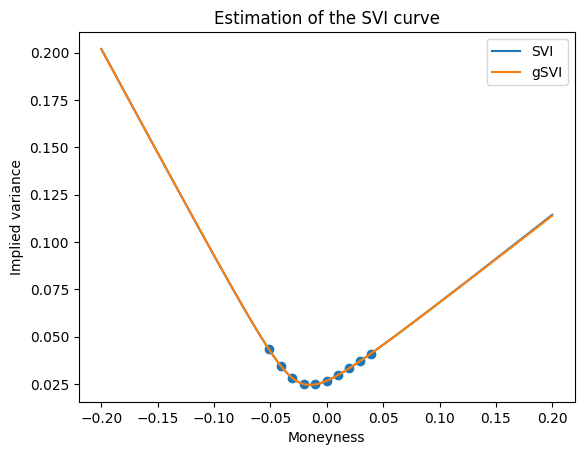

In [350]:
def compute_energy(func, x_data, parameters, y_data):
    estimate = func(x_data, parameters)
    return sum_of_err_squared(y_data, estimate)

# Fit the implied variance which is more regular, to get the volatilities
# then just do sqrt(implied_variance)
implied_variance = [v**2 for v in implied_volatilites]

# If set to True it runs the optimization algorithm, if set to False
# use the optimal parameters found previously 
if False:
    best_par = simulated_annealing(SVI_func, log_moneyness, implied_variance, 10, 2E6)
    generalized_best_par = simulated_annealing(gSVI_func, log_moneyness, implied_variance, 10, 2E6)
else:
    best_par = {'a': 0.007386432463786766, 'b': 0.7915126134339514, 'rho': -0.40739195226558206, 'm': -0.025608667490057614, 'sigma': -0.02373182052187722}
    generalized_best_par = {'a': 0.00652490563018189, 'b': 0.8134782389338896, 'rho': -0.41070426262973697, 'm': -0.02592370814631364, 'sigma': 0.024283975676713476, 'beta': 1.2028620109261117}

# Print and plot the results
print(best_par)
print(f'Final energy: {compute_energy(SVI_func, log_moneyness, best_par, implied_variance)}')
print(f'Final energy (generalized): {compute_energy(gSVI_func, log_moneyness, generalized_best_par, implied_variance)}')

x_axis = np.linspace(-0.2, 0.2, 100)

fig, ax = plt.subplots()
ax.set_title("Estimation of the SVI curve")
ax.set_xlabel("Moneyness")
ax.set_ylabel("Implied variance")
ax.plot(x_axis, SVI_func(x_axis, best_par))
ax.plot(x_axis, gSVI_func(x_axis, generalized_best_par))
ax.scatter(log_moneyness, implied_variance)
ax.legend(["SVI", "gSVI"])
plt.show()

## Dupire's formula

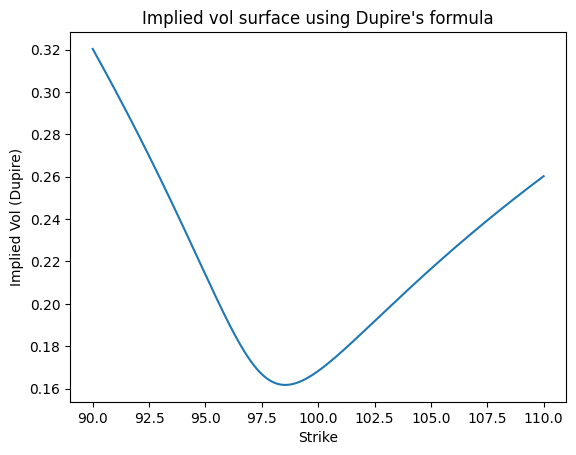

In [ ]:
def Dupire_vol(strike, r, theta, dual_delta, dual_gamma):
    num = 2 * (theta + r * strike * dual_delta)
    den = strike**2 * dual_gamma
    return num / den

# Create the strike grid
strike_grid = [90 + i * 0.01 for i in range(0, 2001)]
SVI_implied_vols = [np.sqrt(SVI_func(np.log(k / spot), best_par)) for k in strike_grid]

# Compute the Dupire's volatilities
dupire_vols = []
for i in range(len(strike_grid)):
    opt_par = BS_price(spot, strike_grid[i], 1, risk_free_rate, SVI_implied_vols[i])
    vol = Dupire_vol(strike_grid[i], risk_free_rate, opt_par["theta"], opt_par["dual delta"], opt_par["dual gamma"])
    dupire_vols.append(vol)

# Plot the results
fig, ax = plt.subplots()
ax.set_title("Implied vol surface using Dupire's formula")
ax.set_xlabel("Strike")
ax.set_ylabel("Implied Vol (Dupire)")
ax.plot(strike_grid, np.sqrt(dupire_vols))
plt.show()

## SVI Model Calibration

{'a': 0.009724763586455812, 'b': 0.8429127632408853, 'rho': -0.3675741677263772, 'm': -0.01844811930245924, 'sigma': 0.01926522976445795}


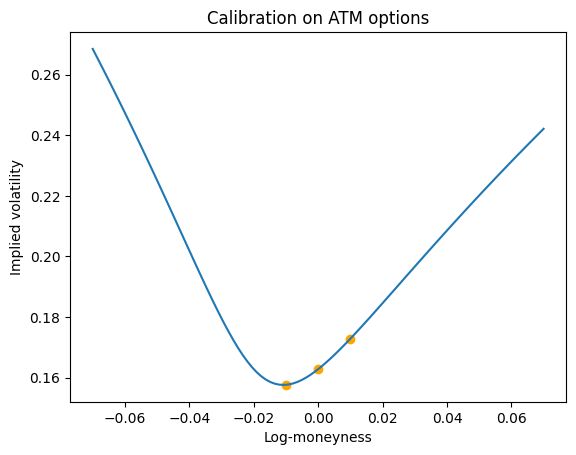

In [17]:
at_the_money_strikes = strikes[4:7]
at_the_money_prices = prices[4:7]
at_the_money_variance = implied_variance[4:7]

log_moneyness = [np.log(k / spot) for k in at_the_money_strikes]

# Calibrate the model only on the three options with closest strike to spot
if False:
    calibrated_par = simulated_annealing(SVI_func, log_moneyness, at_the_money_variance, 10, 2E6)
else:
    calibrated_par = {'a': 0.010264046888319656, 'b': 0.821871732953936, 'rho': -0.35733861978688597, 'm': -0.018090747458748817, 'sigma': -0.018967045336479162}

# Plot the results
print(calibrated_par)
x_axis = np.linspace(-0.07, 0.07, 100)

fig, ax = plt.subplots()
ax.set_xlabel("Log-moneyness")
ax.set_ylabel("Implied volatility")
ax.set_title("Calibration on ATM options")
ax.plot(x_axis, np.sqrt(SVI_func(x_axis, calibrated_par)))
ax.scatter(log_moneyness, np.sqrt(at_the_money_variance), color='orange')
plt.show()

## Pricing with Heston Model
##### Normal random number generator using Metropolis-Hastings algorithm

In [23]:
# Generate random numbers following the standard normal distribution using
# Metropolis-Hastings algorithm
def gauss(shape):
    rows = shape[0]
    columns = shape[1]

    # In order to stabilize the algorithm, the first
    # attempts must be discarded otherwise the convergence
    # to the true distribution will get slower 
    attempts_burned = 100
    
    numbers = []
    for row in range(rows):
        line = []
        previous_guess = random.uniform(-5, 5)
        for i in range(columns + attempts_burned + 1):
            # Generate the next guess
            next_guess = random.uniform(-5, 5)

            # Compute the ratio between the two probabilities
            ratio = np.exp((previous_guess**2 - next_guess**2) * 0.5)

            # Accept or reject the new guess
            if i > attempts_burned:
                threshold = random.uniform(0, 1)
                if ratio > threshold:
                    line.append(next_guess)
                    previous_guess = next_guess
                else:
                    line.append(previous_guess)
        numbers.append(line)

    return numbers

# Introduce a correlation between two lists of random numbers
def correlate(list_1, list_2, correlation):
    list_2 = [list_1[i] * correlation + list_2[i] * np.sqrt(1 - correlation**2) for i in range(len(list_1))]
    return [list_1, list_2]


#### Pricing function using Monte Carlo simulations

In [71]:
def Heston_price(spot, strike, maturity, r, mp, n_sim, n_steps):
    # Initialize the arrays
    prices = np.zeros((n_sim, n_steps + 1))
    variances = np.zeros((n_sim, n_steps + 1))
    prices[:, 0] = spot
    variances[:, 0] = mp["v0"]

    # Initialize starting variables
    dt = float(maturity) / n_steps
    S_t = spot
    v_t = mp["v0"]

    # Simulation
    for t in range(1, n_steps + 1):
        # Generate two correlated normal random vectors with mean = (0, ... , 0)
        # and sigma = sqrt(dt) * Identity_matrix
        Z = np.array(gauss((2, n_sim))) * np.sqrt(dt)
        if mp["correlation"] != 0:
            Z = np.array(correlate(Z[0, :], Z[1, :], mp["correlation"]))

        # Compute the next value and save it
        v_t = np.abs(v_t + mp["kappa"] * (mp["theta"] - v_t) * dt + mp["vol_of_vol"] * np.sqrt(v_t) * Z[1, :])
        S_t = S_t * np.exp((r - v_t * 0.5) * dt + np.sqrt(v_t) * Z[0, :])
        prices[:, t] = S_t
        variances[:, t] = v_t
    
    last = prices[:, -1]
    lastV = variances[:, -1]

    # Compute the price of the option
    payoffs = np.maximum(prices[:, -1] - strike, 0)
    average_payoff = np.sum(payoffs) / len(payoffs)
    option_price = average_payoff * np.exp(-r * maturity)

    # Compute the devstd of the price
    devstd = np.sqrt((np.sum(payoffs**2) / len(payoffs) - average_payoff**2) / (len(payoffs) - 1))
    option_devstd = devstd * np.exp(-r * maturity)

    return option_price, option_devstd, last, lastV

# Example of pricing with Heston
heston_params = {'v0': 0.04, 'kappa': 2., 'theta': 0.04, 'vol_of_vol': 0.5, 'correlation': -0.5}

print(f'Spot: 100  |  Strike: 100  |  Maturity: 1y  | risk free rate: 0.2%')
price, devstd, lastS, lastV = Heston_price(100, 100, 1, 0.02, heston_params, 10000, 252)
print(f'Option price: {price}  |  Devstd of the simulation: {devstd}')


Spot: 100  |  Strike: 100  |  Maturity: 1y  | risk free rate: 0.2%
Option price: 2.7590702950036197  |  Devstd of the simulation: 0.06717149474211556


In [73]:
l = [0.178677, 0.0332597, 0.0798486, 0.0552473, 0.0171502, 0.301605, 0.00485784, 0.116885, 0.0027845, 0.110534, 0.00471828, 0.0354788, 0.0817455, 0.00124088, 0.0239385, 0.00822054, 0.0441868, 0.038223, 0.358114, 0.0101584, 0.0798542, 0.0482118, 0.180876, 0.0722971, 0.393325, 0.0109752, 0.00391987, 0.0899381, 0.127769, 0.176449, 0.496907, 0.319397, 0.249121, 0.140806, 0.000250694, 0.0388434, 0.0799931, 0.831993, 0.00338912, 0.00233313, 0.0058982, 0.112019, 0.0149541, 0.392577, 0.0123665, 0.00142092, 0.00267512, 0.216911, 0.0103026, 0.231857, 0.163525, 0.29094, 0.000210172, 0.0809471, 0.0680448, 0.0184059, 0.377763, 0.0234499, 0.396349, 0.0786989, 0.0268993, 0.106148, 0.0171109, 0.174524, 0.00295097, 0.0760668, 0.666713, 0.0494672, 0.0347369, 0.08744, 0.0319992, 0.00562283, 0.0383858, 0.00733898, 0.001492, 0.0110052, 0.0312747, 0.0124305, 0.00455277, 0.000866898, 0.267659, 0.0805664, 0.000202316, 0.0545482, 0.04414, 0.262239, 0.0396877, 0.000860577, 0.354453, 6.93121e-005, 0.00367921, 0.486061, 0.0158434, 0.000307776, 0.509164, 0.159606, 0.00332028, 0.060647, 0.0236824, 0.0555672, 0.448341, 0.00140559, 0.0373592, 0.0432823, 0.527679, 0.0259802, 0.0389028, 0.104829, 0.120441, 0.0264495, 0.201134, 0.000554015, 0.0431267, 0.169044, 0.228772, 0.000611515, 0.000192679, 0.0200614, 0.0139247, 0.0017158, 0.264804, 0.0558201, 0.19791, 0.314421, 0.00601805, 0.0458465, 0.0387082, 0.111443, 0.19014, 0.0193414, 0.0412916, 0.569761, 0.147386, 0.000393126, 0.0396041, 0.000234696, 0.0588044, 0.101361, 0.444167, 0.00100545, 0.448136, 0.0761311, 0.281732, 0.076112, 0.0621197, 0.0897982, 0.0812559, 0.326519, 0.000847064, 0.101611, 0.524712, 0.235865, 0.0106924, 0.00565851, 0.000121235, 0.0307972, 0.142298, 0.000683776, 0.0790056, 0.116819, 0.0239247, 0.000392919, 0.00617067, 0.226749, 0.0646491, 0.0182313, 0.00528009, 0.000500628, 0.524618, 0.080752, 0.0412119, 0.121916, 0.0414102, 0.000115868, 0.671546, 0.391049, 0.0236146, 0.560251, 0.134506, 0.294367, 0.473349, 0.146, 0.0260555, 0.059275, 0.0196961, 0.00327692, 0.00113107, 0.0176152, 0.106497, 0.077687, 0.179284, 0.251655, 0.802872, 0.0267123, 0.0052719, 0.0958864, 0.0456029, 0.0638228, 0.0671405, 0.305735, 0.0384146, 0.0157609, 2.79816e-005, 0.0254353, 0.0718161, 0.131369, 0.00116172, 0.0130506, 0.557844, 0.00197199, 0.0519812, 0.00942246, 0.000863194, 0.0115905, 0.115867, 0.00583632, 0.0123552, 0.000134129, 0.11435, 0.00481524, 0.0793886, 0.114462, 0.000376451, 0.0102851, 0.278482, 0.015625, 0.0300198, 0.194052, 0.298186, 0.000438088, 0.0153987, 0.0408608, 0.000782609, 0.000867598, 0.117904, 0.284973, 0.227339, 0.000451236, 0.0245331, 0.00824637, 0.00116591, 0.00261068, 0.307108, 0.12834, 0.11727, 0.0226342, 0.0103873, 0.801714, 0.493638, 0.0732286, 0.00715951, 0.344465, 0.00185104, 0.181209, 0.0558513, 0.0249975, 0.1028, 0.505602, 0.0271597, 0.404528, 0.033584, 0.337093, 0.0152058, 0.0799991, 0.0187915, 0.166405, 0.275142, 9.43853e-005, 0.0798568, 0.160918, 0.160541, 0.39483, 0.0119818, 0.0661934, 0.023179, 0.00971474, 0.107303, 0.0464737, 0.163789, 0.0276593, 0.0015891, 0.00321645, 7.64503e-006, 0.0525309, 0.171236, 0.00196455, 0.000531547, 0.0447026, 0.363137, 0.22307, 0.0308766, 0.146898, 0.0178947, 0.00320488, 0.0965768, 0.591482, 0.0885249, 0.10994, 0.0153213, 0.101384, 0.000618394, 0.0151575, 0.290237, 0.0678274, 0.144796, 0.270288, 0.0110602, 0.00154318, 0.00137465, 0.000437064, 0.0668253, 0.0579927, 0.17858, 0.0619187, 0.120693, 0.0586184, 0.000151315, 0.261504, 0.00981416, 0.234292, 0.199033, 0.0814808, 0.0495355, 0.27316, 0.735024, 5.80279e-005, 0.0733333, 5.70822e-006, 0.000128974, 0.298027, 0.00354886, 0.0756355, 0.00639425, 0.0701824, 0.000561362, 0.0563506, 0.39114, 0.308169, 0.133033, 0.220132, 0.0015178, 0.100601, 0.0203582, 0.0290361, 0.00309836, 0.0394024, 0.00617584, 0.0086557, 0.000245165, 0.0118783, 0.000146238, 0.0137703, 0.449816, 0.014739, 0.293617, 0.109976, 0.0884945, 0.382258, 0.0225885, 0.0134567, 0.122002, 0.39826, 0.244179, 0.127566, 0.502591, 0.00360321, 0.0206667, 0.343896, 0.0390491, 0.118068, 0.35216, 0.100211, 0.000716137, 0.192371, 0.101683, 0.0218719, 0.103894, 0.142063, 0.109379, 0.132155, 0.0634435, 0.145609, 0.204583, 0.230981, 0.136525, 0.0346555, 0.0548338, 0.541813, 0.21364, 0.003364, 3.44718e-005, 0.167745, 0.140903, 0.0302034, 0.000416779, 0.020696, 0.33049, 0.393955, 0.060934, 0.0405618, 0.0216709, 0.0453289, 0.155233, 0.108664, 0.0783019, 0.0272342, 0.00343402, 0.000365168, 0.000820186, 0.0881679, 0.00927911, 0.3502, 0.107218, 0.180192, 0.0146032, 0.00183967, 0.00405484, 0.0160469, 0.0155072, 0.353613, 0.307284, 0.220468, 0.141642, 0.214276, 0.160435, 0.439245, 0.000959452, 0.0487336, 0.1641, 0.211161, 0.0312038, 0.105112, 0.0909664, 0.00401473, 0.0991762, 0.0626467, 0.0367924, 0.0809002, 0.0304772, 1.00799, 0.171466, 0.320703, 0.0319843, 0.0111224, 0.275195, 0.185782, 0.296631, 0.00923457, 0.00737846, 0.0458886, 0.252775, 0.619694, 0.00657902, 0.0752029, 0.0247946, 0.0837494, 0.0555476, 0.058096, 0.00960195, 0.193004, 0.13654, 0.00715754, 0.000550065, 0.392708, 0.133332, 0.318066, 0.0690614, 0.124831, 0.00300806, 0.00521288, 0.0269473, 0.000623263, 0.0125416, 0.443627, 0.00172037, 0.00078885, 1.06368e-005, 0.00874729, 0.495369, 0.0260617, 0.134734, 0.0912056, 0.00620944, 0.0280144, 0.00242298, 0.0109472, 0.220425, 0.302808, 0.129356, 0.0557632, 0.277704, 0.00018866, 0.0182085, 0.00327489, 0.210605, 0.675415, 0.0646547, 0.179594, 0.236375, 0.151313, 0.0367483, 0.00979293, 0.0522409, 0.00773723, 0.249113, 0.132945, 0.243029, 0.0161118, 0.00413374, 0.000118539, 0.457032, 0.115559, 0.0347073, 0.0556258, 0.257689, 0.09647, 0.000337393, 0.232882, 0.0107767, 0.295306, 0.0110466, 0.000231972, 0.0154775, 0.178965, 0.333866, 0.0421969, 0.000892957, 0.000783267, 0.1296, 0.12564, 0.0423786, 0.018452, 0.196155, 0.132292, 0.00357261, 0.0962287, 0.240945, 0.12123, 0.0708941, 0.140557, 0.064552, 0.0688548, 0.0348888, 0.668281, 0.0247083, 0.000654495, 0.0298794, 0.00952754, 0.292479, 0.165449, 0.0341892, 0.209724, 0.176397, 0.278511, 0.18092, 0.112193, 0.00054896, 0.513437, 0.000963393, 0.00195295, 0.00011157, 0.0383631, 0.024006, 0.054061, 0.037152, 0.0104916, 0.0106304, 0.10348, 0.0863994, 0.172397, 0.0407389, 0.0256251, 0.0243759, 0.528683, 0.585669, 0.142898, 0.00701466, 0.000631902, 0.4036, 0.00723919, 0.01235, 0.16418, 0.0617389, 0.0169032, 0.0309455, 0.0824896, 0.0477655, 0.000544196, 0.0416562, 0.183588, 0.0596144, 0.0263479, 0.0932124, 0.00402374, 0.294071, 2.80546e-005, 0.0524091, 0.164202, 0.13139, 0.0933467, 0.365792, 0.0121386, 0.00641192, 0.0509526, 0.203591, 0.350237, 0.00944946, 0.239385, 0.0415166, 0.000979024, 0.258884, 0.0169797, 0.015369, 0.00158099, 0.367587, 0.0176808, 0.401746, 0.00494185, 0.0408839, 0.0138277, 0.0256246, 0.365678, 0.00697093, 0.313454, 0.101988, 0.0652115, 0.0895663, 0.0256056, 0.0558277, 0.0897647, 0.00872419, 0.0360103, 0.0207627, 0.162208, 0.536034, 0.445455, 0.102941, 0.158828, 0.0114271, 0.0300368, 0.314955, 0.00686319, 0.896915, 0.175765, 0.00432365, 0.41525, 0.0334474, 0.0485006, 0.209005, 0.154266, 0.00984439, 0.0597893, 0.0525029, 0.00207476, 0.0854352, 0.0174442, 0.229436, 0.000164403, 0.0258687, 0.0653122, 0.0323072, 0.0156362, 0.154529, 0.0448511, 0.0199972, 0.0729078, 0.437686, 0.00136319, 0.00149161, 0.00221617, 0.360792, 0.0368739, 0.908151, 0.0441697, 0.682761, 0.0824769, 0.000820669, 0.0324149, 0.00378635, 0.0771062, 0.00597862, 0.0542491, 0.0252594, 0.0166909, 0.1542, 0.00575471, 0.0457133, 0.01412, 0.000527707, 0.59322, 0.0289867, 0.173683, 0.00474121, 0.0643461, 0.0257363, 0.047089, 0.0337816, 0.000561559, 0.00330548, 0.404473, 0.000387759, 0.0437983, 0.120749, 0.0119164, 0.0438042, 0.0079653, 0.162028, 0.120232, 0.332566, 0.0356859, 0.0318966, 0.0972535, 0.069052, 0.00272229, 0.0892064, 0.150545, 0.0649278, 0.0235849, 0.00366562, 0.000250882, 0.00159625, 0.0681768, 0.22764, 0.217923, 0.00414116, 0.00891397, 0.0092651, 0.0389213, 0.0551616, 0.0467765, 0.000120991, 0.00101636, 0.00613071, 0.12739, 0.0521126, 0.000220533, 0.0116157, 0.00213982, 0.170968, 0.00368899, 0.0106583, 0.266116, 0.497279, 0.0500747, 0.0839655, 0.00191397, 0.0746713, 0.167458, 0.28564, 0.285989, 0.230252, 0.0139106, 0.00733714, 0.00475722, 0.0758451, 0.00641772, 0.130237, 0.0793333, 0.176219, 0.012718, 0.106445, 0.00512541, 0.642537, 0.0562312, 0.086502, 0.00062866, 0.000972048, 0.0174442, 0.0647003, 0.00922484, 0.153186, 0.00570516, 0.0150881, 0.00365393, 0.11106, 0.0015495, 6.91467e-005, 0.0029336, 0.000114142, 0.135362, 0.00925683, 0.139111, 0.0505723, 0.00042329, 0.0146135, 0.26375, 0.28125, 0.0316542, 0.00847044, 1.25384, 0.110014, 0.0237299, 0.29955, 0.00491907, 0.236011, 0.00150562, 0.00621456, 0.020957, 0.511785, 0.180348, 0.0584665, 0.0166836, 0.060945, 0.0723542, 0.018167, 0.0015746, 0.0140531, 0.0901371, 0.0465865, 0.0301803, 0.00127963, 0.140247, 0.00766674, 0.0498316, 0.213467, 0.0291426, 0.312956, 0.0107543, 0.0375519, 0.306973, 0.0435424, 0.0176894, 0.0397427, 0.0106327, 0.00393237, 0.00914037, 0.093512, 0.00110896, 0.0666425, 0.0117374, 8.8544e-005, 0.0570613, 0.0736193, 0.000935136, 0.0912751, 0.0717726, 0.0767626, 0.00147202, 0.182628, 0.00739201, 0.0730683, 0.191216, 0.000811491, 0.0859551, 0.103781, 0.194031, 0.1075, 0.0012977, 0.305279, 0.0895362, 0.547726, 0.000597944, 0.000810233, 0.215148, 0.310462, 0.00939545, 0.152489, 0.031951, 0.0163679, 0.34914, 0.00171449, 0.0587387, 0.224293, 0.241821, 0.00135389, 0.02269, 0.485611, 0.000129756, 0.0863847, 0.474179, 0.000744622, 0.0705616, 0.0149597, 0.092624, 0.2359, 0.624415, 0.979586, 0.389953, 0.0590885, 0.285064, 0.390931, 0.14473, 0.0145117, 0.668117, 0.248136, 0.165834, 0.39295, 0.0845523, 0.0916807, 0.0079045, 0.0939246, 0.57096, 0.104541, 0.0528525, 0.0304293, 0.0242276, 0.0910879, 0.00428606, 0.501323, 0.000385529, 0.0180195, 0.856119, 0.0912384, 0.0555048, 0.080261, 0.201499, 0.0150812, 0.00581391, 0.00943785, 0.0469223, 0.000362107, 0.33662, 0.00142815, 0.29585, 0.0356798, 0.00269837, 0.0404149, 0.176158, 0.0651133, 0.00453539, 0.0380707, 0.157674, 0.429376, 0.143671, 0.010559, 0.00550753, 0.000704465, 0.00373563, 0.153397, 0.00708148, 0.246194, 0.0237248, 0.000109593, 0.103692, 0.451877, 0.0228768, 0.0466447, 0.00645718, 0.186161, 0.0516513, 0.14783, 0.0803627, 0.0760078, 0.505404, 0.0361303, 0.0327665, 0.00724402, 0.0844728, 0.062562, 0.156935, 0.097857, 0.0439727, 0.0284347, 0.220183, 0.159822, 0.237047, 7.50401e-005, 0.0143194, 0.000349393, 0.00707317, 0.0661372, 0.167602, 0.283544, 0.155871, 0.355903, 0.0160905, 0.0173537, 0.60509, 0.225135, 0.00148929, 0.0430199, 0.057857, 0.0398205, 0.0553801, 0.169326, 0.0238524, 0.00676545, 0.365379, 0.0320037, 0.0351495, 0.00502306, 0.0194418, 0.0323281, 0.0133598, 0.122424, 0.0045942, 0.596735, 0.331577, 0.14737, 0.65927, 0.163229, 0.00377449, 0.00743759, 0.00581779, 0.134445, 0.191783, 0.431233, 0.00420588, 0.0108104, 0.0797692, 0.195864, 0.01635, 0.0044124, 0.0204234, 0.290841, 0.0232243, 0.0491189, 0.00440043, 0.0289204, 0.175844, 0.00227827, 7.07112e-005, 0.0628054, 0.0393781, 0.0150968, 0.141162, 0.326408, 0.265551, 0.0899253, 0.0565739, 0.273549, 0.101414, 0.032132, 0.0278154, 0.0701202, 0.0736923, 0.00919766, 0.0919407, 0.0671019, 0.0284576, 0.000407803, 0.558784, 0.0573693, 0.0215496, 0.111457, 0.000768414, 0.000150198, 0.132382, 0.000161936, 0.00157065, 0.072876, 0.0559628, 0.0147412, 0.0110002, 0.0241908, 0.044602, 0.00862052, 0.317893, 0.190727, 0.0231221, 0.179411, 0.0105684, 0.0724092, 0.324466, 0.132938, 0.105784, 0.0282856, 0.000490882, 0.00346774, 0.00369557, 0.00351415, 0.0396694, 0.223399, 0.00805079, 0.50147, 0.227104, 0.0146895, 0.233946, 0.0566905, 0.128464, 0.014442, 0.206036, 0.00074819, 0.326052, 0.202797, 0.0859365, 0.117957, 0.262108, 0.17894, 0.0492007, 0.516367, 0.000591644, 0.00228129, 0.0357301, 0.23678, 0.101802, 0.00853979, 0.0259923, 0.044342, 0.210496, 0.132487, 0.090572, 0.123994, 0.0141942, 0.103085, 0.112794, 0.000986068, 0.0951325, 0.000131354, 0.113408, 0.0793524, 0.16443, 0.230412, 0.200626, 0.0212814, 0.0512811, 0.460067, 0.0101026, 0.0378388, 0.000222667, 0.333455, 0.0468893, 0.00112019, 0.0633816, 0.0406582, 0.0379263, 3.61199e-005, 0.121798, 0.000525014, 0.0676932, 0.261864, 0.424458, 0.00782981, 0.177966, 0.152713, 0.107222, 0.0682365, 0.306121, 0.14856, 0.00149393, 0.170359, 0.0515863, 0.0763168, 0.000499115, 0.152989, 0.256284, 1.12363, 0.0439042, 0.23012, 0.0155042, 0.0439379, 0.0299975, 0.267016, 0.0195576, 0.0764448, 0.401385, 0.32188, 0.28342, 0.0156447, 0.0252383, 0.0112993, 0.0908417, 0.096712, 0.00363533, 0.0597074, 0.157206, 0.00135522, 0.000544028, 0.0249105, 0.0152479, 0.00324945, 0.00112225, 0.0385053, 0.00264752, 0.0440117, 0.0576235, 0.155159, 0.558769, 0.0399745, 0.30519, 0.0170359, 0.175666, 0.30571, 0.120919, 0.361096, 0.22944, 0.00198743, 0.34831, 0.00872072, 0.209887, 0.340071, 0.143296, 0.256929, 0.240942, 0.210361, 0.164177, 0.0407455, 0.190093, 0.390216, 0.0678458, 0.0423778, 0.00954472, 0.0556065, 0.309541, 0.0948928, 0.000182879, 0.188905, 0.0160401, 0.027148, 0.00979634, 0.114918, 0.00130824, 0.0350261, 0.228164, 0.79266, 0.0669999, 0.00789816, 0.00527554, 0.0877566, 0.0603249, 0.00260147, 0.33221, 0.000427191, 0.0685016, 0.0264028, 0.110014, 0.00632557, 1.99041e-005, 0.0652233, 0.0173228, 0.0642489, 0.000881271, 0.00294063, 0.348535, 0.0107931, 0.0146915, 0.0988277, 0.0910262, 0.199182, 0.0839152, 0.00877146, 0.279865, 0.288001, 0.0173313, 0.283378, 0.0386656, 1.3483, 0.0770174, 0.318186, 0.277345, 0.0165271, 0.122085, 0.00891099, 0.133487, 0.0048901, 0.0533892, 0.00433699, 0.014401, 0.393465, 0.024259, 0.31797, 0.0154168, 0.0220101, 0.0613562, 0.0125869, 0.0396882, 0.153481, 0.00622584, 0.0183307, 0.163282, 0.032637, 0.298471, 0.0941622, 0.00763983, 0.00735593, 1.24649, 0.185106, 0.16146, 6.92895e-005, 0.0372371, 0.000660329, 0.00258486, 0.0485639, 0.00514419, 0.0458734, 0.218127, 0.159455, 0.259797, 0.144547, 0.00968369, 0.248367, 0.0997866, 0.0106632, 0.083728, 0.00322665, 0.000745477, 0.00156691, 0.0759751, 0.108935, 0.00319017, 0.0949622, 0.878225, 0.00603057, 0.107405, 0.000587215, 0.0531628, 0.146397, 0.647223, 0.0278511, 0.10341, 0.285697, 0.724673, 0.0827798, 0.0584499, 0.655945, 0.00020158, 0.204961, 0.0215027, 0.0143187, 1.41581e-005, 0.307316, 0.39365, 0.415446, 0.0152112, 0.0326014, 0.0510487, 0.027285, 0.0326517, 9.89024e-005, 0.0255087, 0.18399, 0.000465105, 0.0333839, 0.70219, 0.0122075, 0.000148455, 0.367838, 0.0658221, 2.25181e-005, 0.0281407, 0.230177, 0.0448227, 0.000387278, 0.0324414, 0.00734493, 0.320517, 0.0325136, 0.210013, 0.0421471, 0.00202718, 0.0522906, 0.118188, 0.293193, 0.0704337, 0.0368936, 0.0492249, 0.0699463, 0.00139701, 0.0151636, 0.290708, 0.0329793, 0.184571, 0.0498099, 0.168254, 2.61874e-005, 0.131674, 0.0250911, 0.0137279, 0.0368712, 0.00334093, 0.231858, 0.0632519, 0.0268518, 0.000156753, 0.036603, 0.0204295, 0.154447, 0.0082119, 0.00832924, 0.128116, 0.0262189, 0.00447987, 0.0182416, 0.0723991, 0.200322, 0.000847366, 0.0967657, 0.0196247, 0.0357139, 0.13421, 0.0580538, 0.00219266, 0.00102837, 0.00311346, 0.0950327, 0.00680361, 0.0753626, 0.113179, 0.00191312, 0.0379712, 0.0622571, 0.393194, 0.00763832, 0.163352, 0.039463, 0.460805, 0.0066632, 0.447431, 0.00244242, 0.00916677, 0.00867961, 0.23735, 0.088514, 0.0726632, 0.247926, 0.0876506, 0.00246163, 0.0278006, 0.102971, 0.0806314, 0.0534671, 0.0504217, 0.0259322, 0.108876, 0.00289243, 8.57334e-005, 0.000280235, 0.298157, 0.0428522, 0.0687563, 0.000647783, 0.164564, 0.158696, 0.0814178, 0.248749, 0.0871321, 0.191931, 0.00138539, 0.182253, 0.0276657, 0.104744, 0.404909, 0.819505, 0.000628697, 0.511674, 0.237408, 1.68288, 0.0107062, 0.00419959, 0.0818468, 0.00420987, 0.0068643, 0.354014, 0.0805545, 0.298047, 0.20052, 0.0208689, 0.027203, 0.00264396, 0.0783385, 0.0262995, 0.00157468, 0.191756, 0.00188249, 0.179958, 0.00387414, 0.0217828, 0.0106377, 0.0906771, 0.000315171, 0.0335584, 0.181579, 0.00439098, 0.000974748, 0.401498, 0.145911, 0.643595, 0.000255055, 0.0131107, 0.376634, 0.00383864, 0.00374026, 0.0548799, 0.00168948, 0.012958, 0.0232419, 0.019027, 0.0479861, 0.159607, 0.332044, 0.461791, 0.193012, 0.191286, 0.125553, 0.000166516, 0.202715, 0.00398927, 0.0392436, 0.124768, 5.38856e-005, 0.146683, 0.0846515, 0.16461, 0.0727824, 0.0708225, 0.0506703, 0.00122879, 0.0505387, 0.00318443, 0.0224916, 0.0516829, 0.0592986, 0.468777, 0.265739, 0.0061143, 0.0984369, 0.167707, 0.0473246, 0.709558, 0.00661233, 0.00362599, 0.0603873, 0.04385, 0.222659, 0.0648782, 0.00904347, 0.0300681, 0.0231189, 0.338626, 0.0210313, 0.00330702, 0.0982061, 0.0646522, 0.000124014, 0.444746, 0.241337, 0.157131, 0.209641, 0.650495, 0.33522, 0.0418914, 2.75359e-005, 0.180492, 0.146453, 0.0489587, 0.0636314, 3.25823e-005, 9.15964e-005, 0.060784, 4.92011e-005, 0.0581018, 0.288322, 0.0394779, 0.0349596, 0.00182422, 0.0286607, 0.000638913, 0.000367938, 0.0884569, 0.0339507, 0.0239558, 0.101517, 0.17356, 0.113139, 0.0632217, 0.0982588, 0.578719, 0.232734, 0.132965, 0.00936695, 0.0422201, 0.00075209, 0.0644327, 0.131294, 0.00882496, 0.181863, 0.0113969, 0.0736606, 0.274904, 0.187814, 0.0460007, 0.0862218, 0.00439249, 0.00584392, 0.000446925, 0.10047, 0.000958496, 0.0882179, 0.337716, 0.0445325, 0.000611185, 0.00389822, 0.0540296, 0.11884, 0.00186768, 0.0242739, 0.0171411, 0.00772177, 0.0224013, 0.274098, 0.0253301, 0.240112, 0.017983, 0.0998899, 0.170758, 0.0209911, 0.0752924, 0.13537, 0.034655, 0.0579213, 0.000260999, 0.969864, 0.00603937, 0.257188, 0.0801673, 0.298673, 0.0503343, 0.0135608, 0.101405, 0.0397537, 0.0441174, 0.03489, 0.0134644, 0.00733827, 0.000963205, 0.0814098, 0.300652, 0.000139711, 0.358232, 0.197839, 0.00679694, 0.00233522, 0.000683377, 0.0137258, 0.0081597, 0.00498421, 0.358145, 0.117994, 0.000917558, 0.065853, 0.0203442, 0.0493436, 0.120599, 0.0565611, 0.0784844, 0.018531, 0.186965, 0.0649173, 0.100954, 0.000117077, 0.123923, 0.107216, 0.184642, 0.000252691, 0.109298, 0.239687, 0.0316113, 0.432594, 0.0325624, 0.0105394, 0.219162, 0.0159168, 0.28089, 0.0888392, 0.202081, 0.138712, 0.0134627, 0.333215, 0.130237, 0.434347, 0.272225, 0.0431954, 0.287623, 0.351695, 0.246411, 0.0719995, 0.00320159, 0.0389827, 0.0131963, 0.0511561, 0.135829, 0.220467, 0.0538344, 0.0831748, 0.115599, 0.132952, 0.00998997, 0.000592934, 0.096385, 0.2786, 0.00901379, 0.0858367, 0.0894221, 0.674909, 0.139073, 0.520611, 0.126353, 0.0416614, 0.0902987, 0.0147969, 0.0628732, 0.00936967, 0.0268734, 0.12471, 0.00240883, 0.609169, 0.000103394, 0.00304094, 0.573074, 0.0685777, 0.079818, 0.0292352, 0.406351, 0.184003, 0.020883, 0.0604857, 0.119701, 0.169521, 0.11548, 0.257297, 0.0566072, 0.0725885, 0.05579, 0.00578675, 0.00643578, 0.000456466, 0.00650093, 0.0339832, 0.0882454, 0.0330332, 0.0378494, 0.0906474, 0.0936756, 0.15953, 0.0185512, 0.000414526, 0.0340931, 0.0209174, 0.0264256, 0.0174458, 0.000797865, 0.0110366, 0.00946813, 0.0261449, 0.0816043, 0.0271653, 0.0553487, 0.00494672, 0.438446, 0.0239884, 0.616286, 0.480101, 0.0697233, 0.133416, 0.171753, 0.687798, 0.131352, 0.0212244, 0.0567363, 0.162354, 0.12462, 0.518667, 0.344406, 0.00239587, 0.157633, 0.21758, 0.00127109, 0.528051, 0.00177938, 5.50553e-005, 0.231008, 8.71648e-005, 0.436027, 0.133513, 8.92811e-005, 0.170268, 0.14148, 0.379108, 0.0792292, 0.0024097, 0.028011, 0.00767876, 0.0533581, 0.0361955, 0.0459124, 0.00144077, 0.0596913, 0.0650122, 0.00662437, 0.0107928, 0.0473863, 0.148924, 0.0260588, 0.132508, 0.186841, 0.04352, 0.0710974, 0.186211, 0.0167436, 0.0128199, 0.0266129, 0.102241, 0.0737923, 0.000566283, 0.0303492, 0.0250807, 0.802015, 0.175017, 0.014964, 0.321719, 0.000705529, 0.001173, 0.0329945, 0.0198639, 0.0268265, 0.0626496, 0.000778992, 0.0316426, 0.0750451, 0.181328, 0.097565, 0.050731, 0.103653, 0.00178256, 0.863286, 1.0237, 0.101486, 0.101597, 0.137675, 0.00185408, 0.0524042, 0.294574, 0.0227709, 0.00531124, 0.0586407, 0.161131, 0.0735535, 0.00181558, 0.214191, 0.207378, 0.178456, 0.0943673, 0.354556, 0.00224063, 0.000365993, 0.0591419, 0.0725922, 0.0569357, 0.270123, 0.0648933, 0.161945, 0.644001, 0.0692763, 0.00146245, 0.0976103, 0.0491611, 0.449944, 0.0367979, 0.0389215, 0.00258329, 0.0484704, 0.455683, 0.0230768, 0.174686, 0.163305, 0.166623, 0.337538, 0.0319516, 0.434477, 0.0164315, 0.000743301, 0.0847644, 0.00220517, 0.539029, 0.109889, 0.00181779, 0.0658895, 0.172693, 0.0356424, 0.00162691, 0.175828, 0.000196188, 0.000591416, 0.073029, 0.0100194, 0.0320526, 0.162359, 0.239361, 0.0406128, 0.195301, 0.219015, 0.0153164, 0.185379, 0.0749298, 0.0437476, 0.00287419, 0.0394426, 0.0871679, 0.0563997, 0.206792, 0.0606338, 0.037086, 0.042431, 0.260769, 0.0105054, 0.0235531, 0.411242, 0.143655, 0.0080441, 0.0757394, 0.159722, 0.023787, 0.135141, 0.00138727, 0.103751, 0.540534, 0.390803, 0.196552, 0.00746691, 0.00966162, 0.0170967, 0.397232, 0.489416, 0.113907, 1.06803, 0.0393037, 0.153358, 0.0993892, 0.0109044, 0.000628273, 0.0147109, 0.000151647, 0.0592632, 0.0267686, 0.0046346, 0.0435744, 0.0250379, 0.205974, 0.130032, 0.331848, 0.00340669, 0.260625, 9.36288e-005, 0.0150492, 0.119034, 0.0143128, 0.0954189, 0.102657, 0.0500149, 0.00853167, 0.00109548, 0.0078093, 0.0305457, 0.00398313, 0.00802721, 0.1294, 0.00936221, 0.048929, 0.024787, 0.347174, 0.0139095, 0.00267237, 0.552564, 0.00976923, 0.226309, 0.664094, 0.00748125, 0.0218826, 0.101874, 0.377777, 0.0701678, 0.0087891, 0.0743893, 0.0985008, 0.0428364, 0.107553, 0.10093, 0.55132, 0.0473967, 0.922222, 1.0855, 0.033361, 0.0185714, 0.0491088, 0.006086, 1.43951, 0.0523822, 0.437171, 0.738622, 0.056142, 0.0218427, 0.192494, 0.342345, 0.133105, 0.102915, 0.0380724, 0.683786, 0.000476423, 0.0583188, 0.4714, 0.0383448, 0.0493637, 0.124377, 0.0224343, 0.00341754, 0.19447, 0.520197, 0.0152731, 0.0462687, 0.232208, 0.0630422, 0.024164, 0.0575325, 0.0149, 0.000522996, 0.0916582, 0.114556, 0.0699979, 0.0591906, 0.469078, 0.0020349, 1.20206, 0.0530346, 0.680516, 0.0758791, 0.00151818, 0.0633617, 0.0447548, 0.152079, 0.072914, 0.0115311, 0.453704, 0.0297865, 0.00325964, 0.020624, 0.165881, 0.510028, 0.00650441, 0.24631, 0.0310282, 0.0109128, 0.0289526, 0.324144, 0.262671, 0.0126902, 0.257068, 0.00356104, 0.0161453, 0.00268896, 0.089424, 0.107329, 0.185237, 0.116294, 0.00010743, 0.679924, 0.32032, 0.296163, 0.498929, 0.120408, 0.279704, 0.417391, 0.161337, 0.00929476, 0.0867257, 0.164303, 0.0293228, 0.0398502, 0.0372585, 0.44219, 0.0360709, 0.0140362, 0.333658, 0.0403865, 6.82779e-005, 0.00634422, 0.135882, 0.842809, 0.0460861, 0.0134062, 0.583946, 0.019208, 0.0181963, 0.115854, 0.303761, 0.262506, 0.0542393, 0.0606032, 0.00345824, 0.730735, 0.00390076, 0.100897, 0.136069, 0.115392, 0.111298, 0.0169695, 0.0128651, 0.024014, 0.0326687, 0.0530552, 0.00317535, 0.0164861, 0.211191, 0.45199, 0.0046081, 0.264702, 0.00640485, 0.0363057, 0.0360424, 0.257759, 0.0251021, 0.00694394, 0.0903131, 0.00259514, 0.0224635, 0.103655, 0.165907, 0.000593997, 0.409075, 0.085098, 0.0249568, 0.0639851, 0.0280639, 0.0107208, 0.0252864, 0.00360981, 0.0010151, 0.0198194, 0.00970812, 0.131527, 0.485407, 0.310338, 0.225645, 0.00748469, 0.0351091, 0.000151575, 0.000626425, 0.0110906, 0.215992, 0.273991, 0.77173, 0.0495534, 0.187363, 0.179373, 0.379454, 0.00259466, 0.0224077, 0.0240489, 0.289478, 0.131149, 0.213515, 0.03676, 0.0531463, 0.0108839, 0.443373, 0.000176406, 0.158793, 0.0201581, 0.160542, 0.111161, 0.427458, 0.00278281, 9.71292e-005, 0.0736801, 0.0133846, 0.0144481, 0.0664634, 0.0442689, 0.22961, 0.0285001, 0.0144169, 0.00188429, 0.56679, 0.0390586, 0.0106207, 0.0197834, 0.00262763, 0.131535, 0.0126426, 0.453378, 0.0703196, 0.0438273, 0.0647811, 0.0217958, 0.0922708, 0.138197, 0.135373, 0.0182858, 7.90241e-005, 0.0013867, 0.00286428, 0.433478, 0.618923, 0.0510213, 0.159728, 0.121952, 0.0114827, 0.0403163, 0.105046, 0.00405971, 0.0013778, 0.0337097, 0.000325771, 0.0415247, 0.192011, 0.0411686, 0.0514307, 0.0100686, 0.161469, 0.0207996, 0.121309, 0.0138562, 0.0589059, 0.139392, 0.0333355, 0.00259346, 0.0479405, 0.09532, 0.0473998, 0.139268, 0.0106062, 0.313397, 0.899884, 0.218844, 0.0142108, 0.133343, 0.0172718, 0.053601, 0.0195721, 0.0495811, 0.0181246, 0.148534, 0.368695, 0.000535286, 0.496277, 0.00433377, 0.462533, 0.00446651, 0.137084, 0.0941973, 0.0152132, 0.0129716, 0.00151946, 0.415, 0.0740449, 0.173553, 0.281761, 0.00191904, 0.0315132, 0.265125, 0.641361, 0.0275358, 0.130081, 0.0217504, 0.0438304, 0.307191, 0.0584248, 0.0304261, 0.274882, 0.141385, 0.104844, 0.147538, 0.0259722, 0.0422861, 0.023656, 6.52583e-005, 0.00944636, 0.132007, 0.179434, 0.0206276, 0.004141, 0.0503702, 0.17876, 0.0834787, 0.00632914, 0.246803, 0.182884, 0.002948, 0.0143554, 0.315687, 0.061415, 0.173999, 0.00519946, 0.0130007, 0.0436694, 0.103074, 0.0248396, 0.295043, 0.131818, 0.0183072, 0.276752, 0.69911, 0.175402, 0.172098, 0.260379, 0.00418078, 0.18917, 0.0566844, 0.00010826, 0.22012, 0.00371903, 0.00764812, 0.217953, 0.499394, 0.0468527, 0.363478, 0.0395716, 0.114216, 0.189144, 0.0445989, 0.000428169, 0.00112975, 0.0193138, 0.00196804, 0.0332655, 0.0216852, 0.000923444, 0.246465, 0.315316, 0.10008, 0.0048107, 0.0603803, 0.0942318, 0.0165949, 0.0448996, 0.0488282, 0.0247918, 0.499679, 0.0967265, 0.0149266, 0.0919377, 0.320537, 0.135303, 0.365185, 0.00639468, 0.277814, 0.0250877, 0.502527, 0.0149779, 0.0445994, 0.218876, 0.242108, 0.00393441, 0.00651027, 0.0275593, 0.0222931, 0.00872142, 0.120189, 0.0134285, 0.447958, 0.013423, 0.0332449, 0.455401, 0.457319, 0.217564, 0.276911, 0.00570133, 0.0335002, 0.304789, 0.000714002, 1.09926, 0.736632, 0.0708994, 0.434442, 0.0766762, 0.248377, 0.442594, 0.0369174, 0.0471026, 0.0967997, 0.0608633, 0.00235373, 0.0274023, 0.000705322, 0.0225611, 0.0466431, 0.226174, 0.359744, 0.124635, 0.158838, 0.0287308, 0.565939, 0.0099231, 0.00916819, 0.0194211, 0.000577055, 0.0567052, 0.221611, 0.0446213, 0.0131579, 0.0415544, 0.129436, 0.0646282, 0.00195097, 0.00121854, 0.180446, 0.0203484, 0.0224679, 0.156745, 0.0608487, 9.37073e-005, 0.107356, 0.00311198, 0.103643, 0.0991202, 0.0598839, 0.0267424, 0.0870647, 0.0221315, 0.107956, 0.014115, 0.0626905, 0.000297919, 0.183613, 0.205262, 0.0526536, 0.165071, 0.000593417, 0.00892195, 0.000908422, 0.000941545, 0.0494936, 0.0173996, 0.000281968, 0.190602, 0.235381, 0.00961284, 0.162169, 0.060667, 0.0818064, 0.199378, 0.0203915, 0.026948, 0.427309, 0.100873, 0.000450361, 0.0585452, 0.247646, 0.0556311, 0.290352, 0.0512192, 0.0767312, 0.0376033, 0.0802993, 0.0440719, 0.0372771, 0.0236784, 0.0137877, 0.000106501, 0.0357491, 0.0534673, 0.00301754, 0.237384, 0.0404652, 0.0906219, 0.00110603, 0.0306425, 0.0127563, 0.000231467, 0.0321706, 0.0174088, 0.108311, 0.018062, 0.003493, 0.111349, 0.0579117, 0.204121, 0.000237846, 0.000454737, 0.175007, 0.044475, 0.000648116, 0.139192, 0.00321085, 0.000969081, 0.00494976, 0.0926105, 0.421569, 0.0268467, 0.0108291, 0.568459, 0.292393, 0.047495, 0.241791, 0.194226, 0.0118785, 0.844339, 0.0141545, 0.0715782, 0.176429, 0.00324846, 0.0622521, 0.0012453, 0.10729, 0.0418656, 0.0529375, 0.0894009, 0.0983754, 0.200409, 8.515e-005, 6.48969e-005, 0.0921038, 0.0338718, 0.0148557, 0.0280145, 0.0652793, 0.0547358, 0.0492488, 0.00959645, 0.00258573, 0.198085, 0.0263204, 0.118123, 0.500208, 0.010041, 0.233553, 0.147625, 0.0203565, 0.0232583, 0.00974002, 0.000829175, 0.00816239, 0.284657, 0.239619, 0.452063, 0.00245241, 0.00675807, 0.0634513, 0.124878, 0.231995, 0.280309, 0.15512, 0.401554, 0.0356575, 0.551988, 0.16383, 0.11007, 0.814051, 0.0407232, 0.711212, 0.532443, 0.0721177, 0.0462242, 0.0379357, 0.00178454, 0.256119, 0.223186, 0.436643, 0.00733679, 0.0449099, 0.101145, 0.0363634, 0.044513, 0.0464612, 0.160426, 0.00154343, 0.0167606, 0.207774, 0.00745763, 0.0484328, 0.31298, 0.175257, 0.00318313, 0.010646, 0.0268406, 0.0592016, 0.0137014, 0.00114348, 0.22459, 0.119039, 0.0179306, 0.0233204, 0.328858, 0.0615484, 0.219213, 0.808234, 0.178827, 0.0729574, 0.01008, 0.0426143, 0.0612305, 0.0448177, 0.384864, 0.0163029, 0.035404, 0.129089, 0.0443421, 0.000433549, 0.0306837, 0.100934, 0.101894, 0.130179, 0.0099487, 0.00217189, 0.584742, 0.445907, 0.0178445, 0.0270054, 0.38318, 0.268957, 0.298, 0.584164, 0.0129728, 0.0623504, 0.0141959, 0.0339219, 0.0195593, 0.293618, 0.00012822, 0.0367447, 0.0752238, 0.066991, 0.00163294, 0.226028, 0.0432841, 0.130494, 0.211501, 0.135998, 0.233212, 0.00931772, 0.00226828, 0.00165647, 0.000202362, 0.0107554, 0.0698121, 0.475723, 0.0208923, 0.0427722, 0.37736, 0.586476, 0.0228221, 0.0109474, 0.00041886, 0.0364333, 0.000266608, 0.0147666, 0.0222932, 0.146914, 0.0164599, 0.00330289, 0.000742602, 0.162359, 0.00139892, 0.133581, 0.0412577, 0.218272, 0.000952998, 0.26543, 0.238408, 0.396532, 0.00198482, 0.0112763, 0.00369299, 0.038627, 0.0366324, 0.00113009, 0.063433, 0.0315421, 0.165995, 0.161192, 0.0432721, 1.39456, 0.243539, 0.00963185, 0.0252867, 0.0686069, 0.0887072, 0.266332, 0.0545825, 0.072389, 0.0492547, 0.0256625, 0.00766431, 0.140969, 0.0250918, 0.0130574, 0.0378839, 0.143832, 0.242349, 0.0203555, 0.00244482, 0.0488768, 0.000837615, 1.34372, 0.00232001, 0.000148717, 0.0997758, 0.00083272, 0.0331162, 0.0906242, 0.00255805, 0.12753, 0.00239815, 0.0200131, 0.0181156, 0.0697558, 0.323246, 0.0268666, 0.27161, 0.0121833, 0.147492, 0.208402, 0.283601, 0.0242542, 0.0483862, 0.0643687, 0.0508026, 0.0244546, 0.130636, 0.352213, 0.157257, 1.27787, 0.203153, 0.0632826, 0.042191, 0.422347, 0.0376296, 0.196855, 0.368216, 0.0484889, 0.139058, 0.306621, 0.000650617, 0.824263, 0.0414123, 0.0720357, 0.0142119, 0.0671919, 0.001729, 0.00884774, 0.0107336, 0.366477, 8.76468e-005, 0.0165161, 0.585661, 0.0439563, 0.0671055, 0.00113454, 0.0641266, 0.198444, 0.0458973, 0.0024412, 0.0335362, 0.032054, 0.13798, 0.118098, 0.0316832, 0.0999686, 0.0365163, 0.0207324, 0.0211169, 0.0346603, 0.27349, 0.0497814, 0.000217699, 0.000635302, 0.0379937, 0.00271675, 0.0230499, 0.0119818, 0.0748798, 0.0413128, 0.387358, 0.211816, 0.234239, 0.026262, 0.0419379, 0.0526594, 0.747593, 0.473214, 0.549841, 0.0283466, 0.0167152, 0.313193, 0.0175954, 0.0133, 0.073231, 0.193232, 0.256033, 0.0234743, 0.0803719, 0.0388301, 0.000222878, 4.02364e-005, 0.288079, 0.00158072, 0.0262119, 0.0178756, 0.0370802, 0.00177518, 0.0268472, 0.0270886, 0.0424451, 0.046421, 0.000523301, 0.0883181, 0.445231, 0.100828, 0.033737, 0.090898, 0.0163015, 0.0283374, 0.0212711, 0.0151608, 0.190075, 0.0241542, 6.86263e-005, 0.004134, 0.0945963, 4.3468e-005, 0.00730907, 0.00145863, 0.203219, 0.00207889, 0.288552, 0.181522, 0.0133504, 0.118156, 0.0688589, 0.0652691, 0.0379188, 0.112699, 0.0402301, 0.00787094, 0.0157399, 0.0126444, 0.0022186, 0.000170901, 0.231256, 0.0930934, 0.093092, 0.140313, 0.180487, 0.0330032, 0.020125, 0.000100644, 0.0469688, 0.00800032, 0.225892, 0.120646, 0.138379, 0.381596, 7.24031e-005, 0.00279841, 0.163968, 0.0546792, 0.00785178, 0.00396209, 0.322218, 0.00778625, 0.0683283, 0.0526346, 0.116736, 0.000719423, 0.321335, 0.161615, 0.206246, 0.00861215, 0.306274, 0.070993, 0.000134165, 0.208946, 0.0723374, 0.252188, 0.166326, 0.00407876, 0.22544, 0.00375443, 0.0250306, 0.00332677, 0.169358, 0.0103199, 0.162338, 0.112549, 0.145992, 0.108313, 0.0166448, 0.0250151, 0.130635, 0.0790374, 0.196157, 0.0532176, 0.0242129, 0.254792, 0.0482412, 0.128351, 0.145839, 0.127951, 0.0170493, 0.196647, 0.0674423, 0.000655031, 0.205752, 0.016208, 0.00128616, 0.111791, 0.0607499, 0.00118489, 0.00045802, 0.202016, 0.0817004, 0.317822, 0.069551, 0.129191, 0.10505, 4.83349e-005, 0.539567, 0.00718283, 0.107834, 0.000373467, 0.0082216, 0.470377, 0.096133, 0.0251543, 0.00066305, 0.000443959, 0.374088, 0.1965, 0.183443, 0.111756, 0.111997, 0.0121404, 0.000745053, 0.103431, 0.00553809, 0.092269, 0.14339, 0.0906847, 0.0196101, 0.0840834, 0.00273373, 0.021856, 0.531971, 0.0477312, 0.721191, 0.185942, 0.0167003, 0.0658251, 0.109742, 0.0277948, 0.0838665, 0.011491, 0.000372677, 0.0373612, 0.159531, 0.199763, 0.153883, 0.00589957, 0.46895, 0.066373, 0.000210277, 0.0660247, 0.482311, 0.0877385, 0.00774095, 0.000921698, 0.0272311, 0.044353, 0.0906675, 0.78054, 0.314287, 0.0104445, 0.0225307, 0.206615, 0.0472742, 1.05448, 0.558462, 0.242254, 0.0473616, 0.0323951, 0.16433, 0.255118, 0.028649, 0.0168852, 0.248863, 0.0720954, 0.237016, 0.00336695, 0.0593356, 0.160941, 0.0968166, 0.0391379, 0.000996912, 0.0944909, 0.288239, 0.0158797, 0.089879, 0.0184641, 0.047882, 0.160917, 0.0320769, 0.0328385, 0.274298, 0.341433, 0.000665471, 0.0360087, 0.063352, 0.00109, 0.0313866, 0.0577979, 0.559356, 0.131817, 0.000182382, 0.372145, 0.019624, 0.00874771, 0.12453, 0.0483992, 0.276701, 0.0734094, 0.0102357, 0.0114521, 0.567601, 0.0119704, 0.017082, 0.00102073, 0.00752807, 0.06901, 0.204551, 0.0021976, 0.793434, 0.0562511, 0.11052, 0.034273, 0.0587232, 0.33119, 0.173152, 0.00252861, 0.022805, 0.0134982, 0.0750109, 0.0370201, 0.0220799, 0.00333171, 0.263288, 0.0695651, 0.0251239, 0.183081, 0.0945428, 0.000411353, 0.150148, 0.629755, 0.026078, 0.127539, 0.090484, 0.163951, 0.230726, 0.0891358, 0.142881, 0.0156299, 0.176829, 0.0488359, 0.0177901, 0.235859, 0.301115, 0.0151211, 0.0211571, 0.000120147, 0.0344819, 0.255928, 0.186088, 0.0605708, 0.266463, 0.011376, 0.112428, 0.000139308, 0.585107, 0.196329, 0.231421, 0.00540834, 0.00278413, 0.000142964, 0.191421, 0.00499538, 0.0216672, 0.00512559, 0.145768, 0.0563215, 0.0153571, 0.00255913, 0.0180796, 0.0972386, 0.0583841, 0.299826, 0.0938012, 0.0381835, 9.19539e-005, 0.326744, 4.39405e-006, 0.379751, 0.0358697, 0.0470743, 0.0136526, 0.0222705, 0.139548, 0.180348, 0.0800418, 0.00434739, 0.0593906, 0.362667, 0.292739, 0.00304342, 0.315791, 0.00104211, 0.0586247, 0.00388626, 0.0756809, 0.0442028, 0.126097, 0.000540027, 0.0165865, 0.0318246, 0.0648362, 0.212609, 0.015953, 0.136089, 0.40072, 0.137507, 0.0998996, 0.124591, 0.357207, 0.0117847, 0.0327441, 0.0275596, 0.0127303, 0.0906976, 0.00870499, 0.64346, 0.00226288, 0.00132486, 0.065937, 0.242154, 0.00406882, 0.0134664, 0.0379618, 0.0782526, 0.145706, 0.0650953, 0.0884334, 0.00512545, 0.011697, 0.0171595, 0.0745667, 0.0246486, 0.00222962, 0.10886, 0.133204, 0.0613275, 0.137494, 0.0387804, 0.00333981, 0.0318167, 0.126179, 0.00986245, 0.224722, 0.0131258, 0.130461, 0.410044, 0.0532135, 0.012925, 0.00480693, 0.316874, 0.0072141, 0.0991616, 0.657154, 0.119587, 0.0790047, 0.0010789, 0.0218817, 9.97139e-005, 0.348117, 0.0161373, 0.108148, 0.00312935, 0.109908, 0.156278, 0.0211704, 0.183318, 0.00500631, 0.278229, 0.0211706, 0.0503132, 0.0976423, 0.0418799, 0.0029648, 0.0107692, 0.00115563, 0.0518436, 0.000631389, 0.00200124, 0.024527, 0.000900425, 0.087372, 0.0991853, 0.0053262, 0.0330963, 0.0233684, 0.0241665, 0.0611433, 0.00172779, 0.0663441, 0.357229, 0.0230938, 0.000295194, 0.679469, 0.00397942, 0.036381, 0.0444436, 0.0223672, 0.143926, 0.00824015, 0.0917007, 0.027843, 0.101313, 0.118115, 0.0383513, 0.10537, 0.129132, 0.423289, 0.021512, 0.00230669, 0.000700873, 0.00925891, 0.250635, 0.357735, 0.00153576, 0.00696572, 0.00927268, 0.00226853, 0.0485388, 0.0105941, 0.000381757, 0.0325985, 0.00286339, 0.0109898, 0.0519054, 0.035093, 0.037867, 0.000800951, 0.1812, 0.0280519, 0.126271, 0.0525485, 0.0168548, 0.215846, 0.00243246, 0.00354318, 0.0288468, 0.0578058, 0.0829904, 0.00609549, 0.0268225, 0.312192, 0.0162096, 0.178188, 0.071173, 0.941765, 0.0101732, 0.00848948, 0.0327308, 0.220961, 0.106937, 0.0320433, 0.126421, 0.0579619, 0.0878628, 0.000694957, 0.0340012, 0.00687166, 0.505838, 0.000490186, 0.0634813, 0.0794507, 0.57696, 0.0200931, 0.545791, 0.147286, 0.0645125, 0.00559836, 0.0267576, 0.00299815, 0.194836, 0.155139, 0.000848261, 0.0376164, 0.0665106, 0.000724228, 0.00908873, 0.0538718, 0.0395215, 0.00529307, 0.0128518, 0.0775716, 0.00914725, 0.17447, 0.322301, 0.00021405, 0.0605303, 0.00804101, 0.0466491, 0.0106444, 0.0204472, 8.46603e-005, 0.40678, 0.0485369, 0.0469711, 0.00829833, 0.017371, 0.00855979, 0.000545484, 0.0767234, 0.00109759, 0.023619, 0.00874704, 0.185324, 0.0889823, 0.048519, 0.454543, 0.0142336, 0.0079504, 0.319738, 0.00639664, 0.225766, 0.256292, 0.000439425, 0.0498573, 0.0780703, 0.196395, 0.0939391, 0.00441186, 0.377439, 0.19628, 0.00662445, 0.0227074, 0.280813, 0.298765, 0.000757454, 0.00660929, 0.02304, 0.00785114, 0.0435974, 0.000888682, 0.0991034, 0.0273664, 0.0645699, 0.00627481, 0.0121062, 0.0264723, 0.0145445, 0.115752, 0.0780872, 0.0376793, 0.000968487, 0.0910807, 0.000273428, 0.508885, 0.0334769, 0.00275278, 0.151575, 0.745601, 0.15439, 0.14945, 0.0863467, 0.0940519, 0.0169788, 0.000661234, 0.14618, 0.00093418, 0.0276905, 0.15322, 0.0405393, 7.77213e-005, 0.0794955, 0.0524778, 0.128681, 0.206353, 0.00102265, 0.506512, 0.0193083, 0.0293906, 0.00122786, 0.384679, 0.024192, 0.797931, 0.12069, 0.022443, 0.000866162, 0.0046834, 0.592084, 0.0014837, 0.00517235, 0.0559279, 0.0497661, 0.0445431, 0.418359, 0.000157347, 0.0180634, 0.15902, 0.0100183, 0.0168873, 0.0498334, 0.469956, 0.000158527, 0.0238727, 0.529986, 0.154858, 0.0494755, 0.204767, 0.0200409, 0.00418126, 0.0160081, 0.476909, 0.118067, 0.167253, 0.681849, 0.126927, 0.116187, 0.0993911, 0.118491, 0.0563671, 0.000908041, 0.00695748, 0.0195812, 0.0141723, 0.0417261, 0.0588649, 0.116269, 0.0756815, 0.11771, 0.0681949, 0.0152556, 0.194335, 0.0151753, 0.00724584, 0.0643079, 0.0083872, 0.280207, 0.192102, 0.000909502, 0.546823, 0.125585, 0.0506879, 0.127923, 0.00030728, 0.0277045, 0.000122008, 0.0141398, 0.00115506, 0.0600568, 0.00177625, 0.156057, 0.0209536, 0.000164455, 0.00509953, 0.255713, 0.159889, 0.097903, 0.0252846, 0.000546515, 0.00319685, 0.160916, 0.31532, 2.58261, 0.0109394, 0.0500155, 0.000784805, 0.179085, 0.0285526, 0.0676581, 0.0118796, 0.156891, 0.0218666, 0.033064, 0.0218492, 0.292048, 0.0125241, 0.17246, 0.235076, 0.198656, 0.0818267, 0.014523, 0.138947, 0.406482, 0.228481, 0.0288884, 0.189913, 0.000154611, 9.95913e-005, 0.154863, 0.157122, 0.0973929, 0.0105701, 0.161928, 0.415494, 0.0834338, 0.0938767, 0.252456, 0.0290403, 0.339095, 0.333971, 0.0420897, 0.0173874, 0.0688891, 0.0362065, 0.000819986, 0.0554506, 0.0927886, 0.0246589, 0.110384, 0.0229282, 0.181964, 0.0365877, 0.199453, 0.266732, 0.134558, 0.0870453, 0.00731827, 0.0345223, 0.008448, 0.0685184, 0.000184897, 0.0430484, 0.0681715, 0.098185, 0.142698, 0.0584963, 0.675103, 0.0188518, 0.146597, 0.0622495, 0.192793, 0.077595, 0.302646, 0.0256974, 0.0975955, 0.1146, 0.000122097, 0.0300365, 0.0783107, 0.048034, 0.527489, 0.446607, 0.370087, 0.000890653, 0.0211121, 0.000453645, 0.0360924, 0.097296, 0.337347, 0.0569204, 0.16732, 0.0111189, 0.0539815, 0.122574, 0.294177, 0.268936, 0.0142283, 0.10112, 0.00398224, 0.224469, 0.00617789, 0.00482682, 0.00648939, 0.0406554, 0.00668878, 0.318516, 0.0129023, 0.104706, 0.201204, 0.0358723, 0.0129867, 0.12386, 0.0275682, 0.0538514, 0.219546, 0.0430859, 0.111033, 0.22652, 0.127317, 0.0101119, 0.105519, 0.0136663, 0.0477488, 0.00202993, 0.013149, 0.116053, 0.755636, 0.0107787, 0.506553, 0.566726, 0.0170819, 0.0066648, 0.0139578, 0.00779126, 0.0760377, 0.00189197, 0.122214, 0.174114, 0.0384773, 0.15783, 0.000557251, 0.0983053, 0.0397799, 0.53539, 0.0435242, 0.384215, 0.228068, 0.120545, 0.226993, 0.490917, 0.000973371, 0.0834236, 0.20339, 0.121362, 0.000577633, 0.245482, 0.00065204, 0.0677723, 0.521635, 0.369311, 0.0264983, 0.0299532, 0.00028827, 0.037445, 0.270518, 0.034952, 0.0442086, 0.0425406, 0.0481113, 0.0576218, 0.432482, 0.190699, 0.277433, 0.111319, 0.11423, 0.311914, 0.0761973, 0.0102019, 0.000402107, 0.311356, 0.13421, 0.202084, 0.168395, 0.000152577, 0.000128938, 0.0374268, 0.0303885, 0.455445, 0.07296, 0.00117638, 0.0707703, 0.0592706, 0.00027877, 0.0642343, 0.195586, 0.0487265, 0.00104341, 0.00191376, 0.280114, 0.0323682, 0.020841, 0.0494645, 0.164555, 0.325248, 0.69818, 0.0151134, 0.0248029, 0.253321, 0.0357043, 0.195115, 0.173465, 0.0278189, 0.465025, 0.00131754, 0.00785276, 0.127316, 0.174106, 0.034708, 0.0414923, 0.519829, 0.0188044, 0.168492, 9.35607e-006, 0.00839494, 0.141757, 0.242137, 0.297493, 0.0167578, 0.0964025, 0.16479, 0.165136, 0.00136731, 0.266825, 0.111348, 0.340598, 0.196828, 0.0667703, 0.000803316, 0.323267, 0.0309165, 0.108503, 0.019299, 0.0766094, 0.247515, 0.0151907, 0.11077, 0.501927, 0.031577, 0.0303075, 1.57858, 0.301089, 0.0348045, 0.0185779, 0.323289, 0.0932672, 0.0166356, 0.0525009, 0.0135384, 0.192039, 0.0136468, 0.144036, 0.135782, 0.0831934, 1.11902e-005, 0.182285, 0.00709691, 0.0362059, 0.0280143, 0.0597135, 0.1424, 0.00998863, 0.560343, 0.0537654, 0.0135866, 0.0899438, 0.0595097, 0.035769, 0.00323554, 0.0570544, 0.0647442, 0.385101, 0.00563922, 0.462536, 0.0269857, 0.300876, 0.135549, 0.133935, 0.0780732, 0.00595303, 0.0553193, 0.0892198, 0.0307866, 0.142032, 0.0587325, 0.00292762, 0.257376, 0.000533922, 0.0816282, 0.00859203, 0.172827, 0.222966, 0.0287661, 0.257305, 0.379834, 0.115926, 0.0056291, 0.169579, 0.116659, 0.0579575, 0.0026896, 0.0254712, 0.227945, 0.000826025, 0.0117074, 0.000207873, 0.0274142, 0.150697, 0.0198715, 0.000950059, 0.555259, 0.00102095, 0.0696776, 0.0284068, 0.0131619, 0.0572595, 0.523323, 0.105661, 0.0275522, 0.0505337, 0.0426401, 0.00636764, 0.0643195, 0.0555861, 0.00993774, 0.268104, 0.00817479, 0.0207021, 0.0260269, 0.188197, 0.754887, 0.191682, 0.00138813, 0.159497, 0.0556353, 0.000148783, 0.0383933, 0.05183, 0.0208391, 0.0251037, 0.515327, 0.0151367, 0.157496, 0.0625668, 0.321967, 0.222585, 0.00011242, 0.397123, 0.0552259, 0.0925753, 0.139425, 0.115471, 0.148954, 0.00793274, 0.225676, 0.137753, 0.0155735, 0.0240085, 0.0541302, 0.0674005, 0.0660413, 0.000115544, 0.0557916, 0.152634, 0.119547, 0.031314, 0.00299659, 0.0505649, 0.00877458, 0.00392109, 0.0967997, 0.0004187, 0.00195903, 0.0503422, 0.00502453, 0.0776026, 0.0202117, 0.214504, 0.0341906, 0.136584, 0.110933, 0.0281135, 0.00288219, 0.00028529, 0.433611, 0.0969165, 0.103201, 0.104368, 0.312954, 0.0142131, 0.25926, 0.0104587, 0.0547971, 1.28151, 0.0356687, 0.119229, 0.0188425, 0.0166838, 0.0709977, 0.0143168, 0.11876, 0.00667641, 0.0150001, 0.107063, 0.130096, 7.86617e-005, 0.125592, 0.0421524, 0.2523, 0.0125125, 0.00453581, 0.0860798, 0.142684, 0.147306, 0.122622, 0.00149709, 0.0265546, 0.0218766, 0.0395052, 0.00384289, 0.0464574, 0.0245874, 0.189789, 0.00575189, 0.0655849, 0.0675615, 0.168818, 0.0262436, 0.0763448, 0.00860487, 0.110883, 0.0362762, 0.24249, 0.00935716, 0.0759516, 0.0645048, 0.138185, 0.20276, 0.0689607, 0.105986, 0.219609, 0.342306, 0.068054, 0.00432429, 0.153438, 0.081829, 0.107058, 0.0966225, 0.11725, 0.00989275, 0.0225296, 0.0240388, 0.0130744, 0.137256, 0.210982, 0.0218112, 0.21332, 0.0069703, 0.0017515, 0.0330755, 0.000160121, 0.172749, 0.0714533, 0.355557, 0.00171983, 0.0059352, 0.0448526, 0.0145117, 0.0158991, 0.0285997, 0.0179346, 0.0241632, 0.0448756, 0.312559, 0.21846, 0.044177, 0.223793, 0.0119596, 0.715533, 0.0497105, 0.0181505, 0.143974, 0.0114051, 0.303631, 0.00910558, 0.0160002, 0.0191853, 0.0206271, 0.10616, 0.298529, 0.0595731, 0.113224, 0.537118, 0.00508839, 0.00787244, 0.0694136, 0.0454185, 0.334945, 9.84233e-005, 0.241636, 0.00398533, 0.164115, 0.00739735, 0.000801973, 0.246882, 0.793115, 0.0818967, 0.0626695, 0.000116611, 0.00209891, 0.00391267, 0.000156739, 0.109875, 0.01386, 0.00378575, 0.294104, 0.274737, 1.49638, 0.63268, 0.00277344, 0.217536, 0.259602, 0.242601, 0.0955124, 0.145934, 0.00641253, 0.00856564, 0.0336853, 0.0365082, 0.0564371, 0.230123, 0.584095, 0.164558, 0.0844379, 0.0332728, 0.00136403, 0.116566, 0.106375, 0.0559214, 0.120469, 0.0733493, 0.00377407, 0.071793, 0.130985, 0.169825, 0.0466749, 0.0191338, 0.141639, 0.0021472, 0.304093, 0.00507985, 0.0012313, 0.242937, 0.43952, 0.0294668, 0.152275, 0.0136434, 0.0479542, 0.0854458, 0.102231, 0.118023, 0.000477833, 0.106004, 0.814622, 0.311211, 0.766025, 0.00811187, 0.00274833, 0.440705, 0.0141858, 0.026723, 0.0821718, 0.170695, 0.246045, 0.0728723, 0.0161604, 0.0262422, 0.52389, 0.194265, 0.00419958, 0.0664583, 0.00819048, 0.0773394, 0.000353001, 0.262682, 0.00655415, 0.109378, 0.0265807, 0.243119, 0.00882149, 0.00670366, 0.151458, 0.86735, 0.120069, 0.492192, 0.157121, 0.00576959, 0.0547737, 0.00857154, 0.00553394, 0.00751509, 0.0791708, 0.00275862, 0.00146606, 0.00562495, 0.061161, 0.0863036, 0.110962, 0.00116564, 0.203017, 0.00970274, 0.00530276, 0.1467, 0.127899, 0.136366, 0.390647, 0.152274, 0.0783914, 0.113857, 0.00653703, 0.017037, 0.0480887, 0.0916239, 0.000363434, 0.00232091, 0.0108862, 0.0118601, 0.012313, 0.0115151, 0.000110793, 0.226501, 0.000995875, 0.160364, 0.0261266, 0.420732, 0.0125431, 0.0152373, 0.00292115, 0.144504, 0.108624, 0.0229614, 0.236488, 0.0730173, 0.0185821, 0.258392, 0.00171114, 0.0350194, 0.695929, 0.0230352, 0.00571303, 0.0768795, 0.000175863, 0.0725508, 0.136341, 0.0336683, 0.0347954, 0.00355901, 0.0195455, 0.00269537, 0.000103983, 0.0104588, 0.172786, 0.0464157, 0.000580994, 0.302644, 0.105289, 0.251868, 0.0853994, 0.0676386, 0.0518875, 0.00373823, 0.201344, 0.0931844, 0.293465, 0.109437, 0.0338797, 0.135893, 0.0200916, 0.116842, 0.000312399, 0.0675994, 0.123894, 0.0273525, 0.0781409, 0.0498045, 0.101006, 0.00293262, 0.202767, 0.0184287, 0.0153865, 0.222897, 0.268809, 0.0481658, 0.00558696, 0.00882523, 0.359965, 0.00249968, 0.00177873, 0.0111679, 0.0132476, 0.0113471, 0.0517592, 0.00432017, 0.141316, 0.0121137, 0.00268289, 0.297309, 0.254445, 0.000222858, 0.0990318, 0.0073551, 0.00635275, 0.0049048, 0.0340859, 0.000341857, 0.331512, 0.0291661, 0.106873, 0.060072, 0.111169, 0.145804, 0.0314819, 0.0152841, 0.116431, 0.0356511, 0.170247, 0.0774253, 0.00052289, 0.0727463, 0.026398, 0.016354, 0.098959, 0.0599912, 0.202356, 0.0605035, 0.075777, 0.0348509, 0.208202, 0.0489972, 1.0181e-005, 0.0627785, 0.647397, 0.049051, 0.177877, 0.0338481, 0.241424, 0.157283, 0.402101, 0.119636, 0.0131679, 0.125921, 0.0638878, 0.000131851, 0.0907139, 0.0250222, 0.19173, 0.186351, 0.042445, 0.00463783, 0.020579, 0.0177901, 0.118656, 0.00699584, 0.00282547, 0.0525462, 0.081721, 0.0164307, 0.0350394, 0.000868676, 0.000821178, 0.18055, 0.0492498, 0.00214315, 0.280754, 0.454385, 0.00463654, 0.614496, 0.00743892, 0.232458, 0.356289, 0.255812, 0.000518679, 0.242336, 0.0109563, 0.00494724, 0.120681, 0.104485, 2.26236e-005, 0.145655, 0.00207136, 0.000760442, 0.000103594, 0.000412271, 0.00327312, 0.38807, 0.0815432, 0.00155576, 0.316595, 0.249984, 0.107097, 0.0434634, 0.0163751, 0.803544, 0.0180118, 0.317804, 0.0311796, 0.406913, 0.556352, 0.0349828, 0.237939, 0.621941, 0.109557, 0.04572, 0.0216661, 0.000179057, 0.00425844, 0.00419044, 0.0780948, 4.75608e-006, 0.226403, 0.101828, 0.00332841, 0.0491353, 0.121207, 0.0793699, 0.377994, 6.79424e-005, 0.1023, 0.0440733, 0.0273715, 0.237425, 0.106753, 9.07621e-005, 0.0253604, 0.0886642, 0.0162452, 0.125436, 0.343846, 0.00584106, 0.036042, 0.0732733, 0.475668, 0.00476484, 0.0550336, 0.159732, 0.454739, 0.00816758, 0.0626882, 0.0367941, 0.0451811, 0.0755427, 0.0462035, 0.0213342, 0.146829, 0.313446, 0.011764, 0.343891, 0.00216728, 0.000384648, 0.665574, 0.0266921, 0.0867507, 0.0354728, 0.0150718, 0.0172636, 0.0256154, 0.481561, 0.0512635, 0.0578961, 0.368571, 0.459708, 0.0695397, 0.172483, 0.0126315, 0.604197, 0.100616, 0.0220212, 0.0709474, 0.0300134, 0.000372914, 0.00215151, 0.0460333, 0.13181, 0.0273052, 0.237411, 0.111666, 0.00591304, 0.286538, 3.71267e-005, 2.33632e-005, 0.00861461, 0.0396129, 0.345931, 0.0092651, 0.0920979, 0.348142, 0.00594728, 0.104298, 0.328649, 0.212881, 0.0211549, 0.00014101, 0.012005, 0.0026949, 0.0922866, 0.0159151, 0.0146303, 0.269819, 0.193426, 0.588417, 0.269677, 0.00433151, 0.00775969, 0.174734, 0.427361, 0.0627193, 0.0127356, 0.219134, 0.0626737, 0.0171329, 0.00110264, 0.00934471, 0.0361029, 0.186438, 0.0397365, 0.0018358, 0.0883916, 0.038157, 0.00437706, 0.0648174, 0.0307669, 0.081337, 0.0490976, 0.0424821, 0.0746109, 0.386298, 0.000235956, 0.0997046, 0.126219, 0.000152608, 0.313074, 0.384782, 0.0622558, 0.00645967, 0.0455568, 0.0366672, 0.166324, 0.0818565, 0.0136152, 0.00115835, 0.0314227, 0.100655, 0.000514861, 0.000856052, 0.000260684, 0.0424627, 0.00331003, 0.176299, 0.0386355, 0.00492477, 0.0472222, 0.0262661, 0.014871, 0.0102869, 0.107176, 0.00042096, 0.129377, 0.000392737, 0.472514, 0.132221, 0.0084289, 0.0381906, 0.0213053, 0.0148592, 0.216288, 0.00153522, 0.077557, 0.0302075, 0.000332885, 0.0483721, 0.0643283, 0.00118492, 0.411282, 0.107013, 0.00263142, 0.569678, 0.518051, 0.254575, 0.0434613, 0.0645634, 0.00126831, 0.0712296, 0.00393159, 0.730496, 0.119377, 0.328808, 0.0179095, 0.162572, 0.0080941, 0.0936438, 0.0598509, 0.0578252, 0.0067218, 0.139888, 3.84711e-005, 0.000437674, 0.056609, 0.00236591, 0.170332, 0.166508, 0.172475, 0.192849, 0.0355261, 0.0890028, 0.0583927, 0.137556, 0.275868, 0.00421359, 0.0480414, 0.0468089, 0.00195388, 0.238834, 0.0563331, 0.327333, 0.0917015, 0.0226624, 0.0301988, 0.14641, 0.00163316, 0.247353, 0.0602583, 0.0991875, 0.126428, 0.161539, 0.000570797, 0.0218406, 0.00267789, 0.00228673, 0.0662145, 0.000512684, 0.0603699, 0.0044488, 0.0824678, 0.101188, 0.00954135, 0.208435, 0.161954, 0.0763031, 0.0224475, 0.000139987, 0.242686, 0.0370786, 0.00355457, 0.0115668, 0.17046, 0.10751, 0.133387, 0.0169278, 0.252789, 0.0146717, 0.162935, 0.00133241, 0.0166954, 2.85443e-005, 0.0788534, 0.0119956, 0.0253933, 0.0767555, 0.479592, 0.21786, 0.221898, 0.0442324, 0.132202, 0.0792676, 0.00366483, 0.359174, 0.00286523, 0.0398161, 0.00163472, 0.110599, 0.07404, 0.111205, 0.0541817, 0.592401, 0.000111928, 0.139476, 0.0105376, 0.00781963, 0.481834, 0.00049474, 0.722075, 0.0252204, 0.252686, 0.00633231, 0.000613041, 0.0683371, 0.0335615, 0.000995268, 0.265494, 0.235091, 0.00354949, 0.0211413, 0.314786, 0.0019349, 0.234911, 0.000548359, 0.00411502, 0.0184448, 0.015593, 0.00405399, 0.0408239, 0.0117298, 0.000597691, 0.203844, 0.0434968, 0.0206365, 1.0371, 0.0703739, 0.0290549, 0.000253716, 0.0105819, 0.215705, 0.0201719, 0.677854, 0.597883, 0.105013, 0.179957, 0.0585367, 0.0300658, 0.0162435, 0.359808, 0.000266904, 0.0727486, 0.2894, 0.148095, 0.551805, 0.0750678, 0.137955, 0.0078595, 0.0721338, 0.0184152, 0.0244744, 0.138823, 0.0392716, 0.0524807, 0.213374, 0.151774, 0.0218436, 0.0996452, 0.575809, 0.326474, 0.0765533, 0.0662782, 0.0106774, 0.129455, 0.280695, 0.273949, 0.240115, 0.175714, 0.0225228, 0.175447, 0.0822378, 0.139534, 0.272052, 0.00160414, 0.0236675, 0.23045, 0.0884095, 0.154693, 0.0293926, 0.0492638, 0.00795549, 0.296047, 0.113629, 0.325719, 0.360295, 0.490137, 0.0420831, 0.347058, 0.178546, 0.138885, 0.00233896, 0.360222, 0.0564767, 0.0209155, 0.0863725, 0.00226968, 0.0793413, 0.0350144, 0.0149762, 0.198643, 0.00721396, 0.00948694, 0.26661, 0.152508, 0.121581, 0.176313, 0.164293, 0.020003, 0.0103217, 0.7703, 0.338477, 0.000216777, 0.15172, 0.110832, 0.25808, 0.00492358, 0.000635781, 0.0467931, 0.385865, 0.234443, 0.00331723, 0.000285678, 0.000198412, 0.000108804, 0.00358757, 0.330407, 0.26698, 0.0173954, 0.174826, 0.00388841, 0.000928968, 0.00739726, 0.00529944, 0.182252, 0.0539709, 0.00282063, 0.000579608, 0.0347317, 0.151376, 0.140074, 0.0291678, 0.375357, 0.00465532, 0.350235, 0.162674, 0.118913, 0.0383871, 0.0493446, 0.223415, 0.0340392, 0.011131, 0.00243756, 0.0655392, 0.0807416, 0.0189666, 0.321223, 0.20652, 0.0122076, 0.124021, 0.117845, 0.265819, 0.0991674, 0.344211, 0.0271996, 0.150369, 0.502028, 0.00265204, 0.253025, 0.0577217, 0.0027568, 0.00334747, 0.00516454, 0.135951, 0.243045, 0.0330052, 0.354295, 0.0840691, 0.141568, 0.0159661, 0.00209473, 0.0714009, 0.0556549, 0.286473, 0.0178829, 0.00593183, 0.0855786, 0.128271, 0.0743288, 0.546031, 0.0248634, 0.00270424, 1.37074e-005, 0.042663, 0.00948222, 0.381544, 0.0949895, 0.659628, 0.000138139, 0.307041, 0.812426, 0.0475705, 0.040296, 0.00912027, 0.0264632, 0.188154, 0.297653, 0.330137, 0.037629, 0.128506, 0.0720564, 0.107606, 0.245608, 0.46281, 0.0987919, 0.000544722, 0.0141434, 0.0468997, 0.904488, 0.0027982, 0.308091, 0.246894, 0.140793, 0.0365167, 0.0222928, 0.0569608, 3.72646e-006, 0.0178413, 0.301646, 0.00337356, 0.0665756, 0.223511, 0.264136, 0.141678, 0.0614255, 0.00080095, 3.43043e-005, 0.341225, 0.0558579, 0.0972664, 3.5251e-007, 0.0782977, 0.00395963, 0.0109483, 0.00266629, 0.18819, 0.10536, 0.0616913, 0.0318744, 0.176181, 0.130127, 0.171729, 0.000645221, 0.0436287, 0.0286871, 0.0974379, 0.00714717, 0.00844684, 0.366003, 0.402591, 0.0627189, 0.236959, 0.103173, 0.26719, 0.259735, 0.0158305, 0.0154051, 0.248014, 0.672972, 0.0420767, 0.132124, 0.000346432, 0.000260853, 0.0632814, 0.12755, 0.0268469, 0.0379992, 0.163465, 0.000271748, 0.224725, 6.94986e-005, 0.00903316, 0.022537, 0.0225018, 0.0084253, 0.00498287, 0.0353277, 0.053111, 0.0270453, 0.0281228, 0.0110129, 0.422866, 0.0236371, 0.263501, 0.0393833, 0.18001, 0.155783, 0.0246479, 0.183821, 0.00220386, 0.238414, 0.00447701, 0.414063, 0.234299, 0.069457, 0.0930604, 0.410559, 0.0380273, 0.277792, 0.00295588, 0.170471, 0.0782229, 0.356284, 0.270378, 0.0184178, 0.0281752, 0.00104837, 0.0139409, 0.019274, 0.124258, 0.196282, 0.00459365, 0.128186, 0.0955223, 0.0211031, 0.283357, 0.0298914, 0.0319234, 0.0190646, 0.0555743, 0.0186831, 0.167155, 0.00299163, 0.00072782, 0.00012641, 0.138605, 0.144796, 0.341004, 0.0915902, 0.0953215, 0.113135, 0.0578439, 0.0145917, 0.016664, 0.0148264, 0.225697, 0.00077542, 0.052868, 0.286538, 0.00753065, 0.000137491, 0.078252, 0.0516122, 0.390662, 0.00306675, 0.0318871, 0.0139578, 0.139998, 0.239926, 0.00190424, 0.00115371, 0.0641622, 0.00476877, 0.0234309, 0.00574746, 0.0614903, 0.57837, 0.0486314, 0.0241398, 0.472117, 0.0345404, 0.166267, 0.150028, 0.102675, 0.000349867, 0.0212856, 0.010592, 0.0523059, 0.033674, 0.0079672, 0.0472256, 0.0155426, 0.0487525, 0.0276049, 0.117004, 0.194654, 0.0406519, 0.00197226, 0.000894618, 0.339406, 0.00415872, 0.0347855, 0.174486, 0.0151649, 0.0765219, 1.01553, 0.0256183, 0.0299541, 0.0860957, 0.000431367, 0.0405518, 0.1807, 0.0239615, 0.0146513, 0.0335704, 0.000285336, 0.112121, 0.196865, 0.165194, 0.00191244, 0.00263121, 0.00121227, 0.277489, 0.0247059, 0.472587, 0.041467, 0.00207083, 0.0675405, 0.0118499, 0.00131275, 0.000301022, 0.0125291, 0.214547, 0.0185502, 0.161399, 0.105946, 0.37648, 0.00736764, 0.0196766, 0.0226271, 0.105702, 0.13764, 0.122514, 0.169599, 0.00595378, 0.0490794, 0.287017, 0.0186288, 0.424105, 0.125154, 0.102657, 0.0981325, 0.474392, 0.075661, 0.0189185, 0.05486, 0.0459994, 0.0126546, 0.0173788, 0.294694, 0.0545561, 0.00786164, 0.0212394, 0.226969, 0.0740815, 0.00392266, 0.0674439, 0.236304, 0.170149, 0.0286816, 0.0817709, 0.066084, 0.101653, 0.0127602, 0.0181346, 0.0235888, 0.101313, 0.346874, 0.0164836, 0.164207, 0.0336427, 0.198776, 0.103218, 0.0126404, 0.318075, 0.0280556, 0.148412, 0.246697, 0.138186, 0.183527, 0.0215941, 0.00268642, 0.00137747, 0.715314, 0.0416816, 0.119197, 0.458745, 0.0232923, 0.532537, 0.00860167, 0.114877, 0.0036484, 0.174573, 0.0490359, 0.104164, 0.00114359, 0.0104462, 0.0695265, 0.00107676, 0.00386488, 0.145269, 0.0102709, 0.415446, 0.052265, 0.248831, 0.263283, 0.0426755, 0.109034, 0.0692336, 0.0013531, 0.00431617, 0.0196689, 0.181065, 0.00495679, 0.0618217, 0.445436, 0.040784, 0.249986, 0.0288249, 0.00576547, 0.0711266, 0.409782, 0.120475, 0.00595781, 0.523906, 0.230585, 0.00917815, 0.317302, 0.0480164, 0.162718, 0.0161932, 0.00400117, 0.000364166, 0.0585824, 0.115143, 0.0849799, 0.00714148, 0.190287, 0.106436, 0.645601, 0.0356562, 0.0415665, 0.0542164, 0.398618, 0.0683808, 0.185367, 0.147939, 0.299974, 0.0533559, 0.0326249, 0.036251, 0.048768, 0.184868, 0.215854, 0.13331, 1.12778, 0.0973999, 0.0530546, 0.259089, 0.327102, 0.00592846, 0.353347, 0.134223, 0.0706103, 0.193266, 0.0598606, 0.0546333, 0.222366, 0.391936, 0.105334, 0.0257222, 0.1094, 0.000600778, 0.0357493, 0.00459847, 0.198025, 0.0158808, 0.143261, 0.382104, 0.556479, 0.000217607, 0.000128747, 0.00339539, 0.0789708, 0.343514, 0.017538, 0.508365, 0.00292306, 0.000110515, 0.00937052, 1.01195, 0.134707, 0.0830324, 0.032952, 0.0889082, 0.120917, 0.1102, 0.0214941, 0.0389259, 0.00969171, 0.32328, 0.0983272, 0.12821, 0.281313, 0.000138268, 0.0318794, 0.0641392, 0.204132, 0.0918792, 0.091779, 0.0823413, 0.0346585, 0.116002, 0.0198312, 0.683356, 0.0947142, 0.089997, 0.646405, 0.152533, 0.0112747, 0.0295439, 0.0971207, 0.00971095, 0.18557, 0.0762305, 0.099941, 0.00178792, 0.0565499, 0.00593573, 0.02855, 0.000475924, 0.00126054, 0.000109863, 0.959678, 0.0119277, 0.0167021, 0.0117916, 0.000573948, 0.112989, 0.890496, 0.0639408, 0.0882563, 0.948005, 0.519065, 0.0754793, 0.00531463, 0.278454, 0.000114925, 0.0300489, 0.144823, 0.0063943, 0.122249, 0.379745, 0.125554, 0.0423729, 0.07345, 0.0362765, 0.00010934, 0.294879, 0.0265163, 0.00524013, 0.00296433, 0.194897, 0.00737495, 0.291579, 0.054172, 0.0465577, 0.149127, 0.681336, 0.0611272, 0.145002, 0.00976096, 0.738519, 0.288186, 0.0505097, 0.00249007, 0.153586, 0.0430717, 0.0758243, 0.193003, 0.688312, 0.121786, 0.179764, 0.399451, 1.44843, 0.0140676, 0.185456, 0.20138, 0.105353, 0.0110201, 0.0642994, 0.0230345, 0.0891118, 0.000616769, 0.00972329, 6.37221e-005, 0.0799307, 0.155785, 0.0695703, 0.303215, 0.149044, 0.0030421, 0.141835, 0.0777044, 0.150518, 0.00960412, 0.0584181, 0.0814513, 0.342899, 0.132022, 0.0221026, 0.0501117, 0.0793226, 0.0335363, 0.0126994, 0.361898, 0.0227711, 0.258066, 0.0655435, 0.000248504, 0.00658866, 0.0263502, 0.000219194, 0.106647, 0.299705, 0.00297939, 0.0047481, 0.0041844, 0.0781074, 0.0533171, 0.0159266, 0.231735, 0.0303588, 0.00282882, 0.00221206, 0.109126, 0.0579326, 0.36386, 0.00319727, 0.0193803, 0.0881502, 0.12227, 0.070891, 0.0338457, 0.514152, 0.0291889, 0.011045, 0.0143481, 0.0295586, 0.00280531, 0.0211088, 0.113197, 0.00300524, 0.175086, 0.0990376, 0.00680532, 0.0409899, 0.0454749, 0.405438, 0.0773173, 0.0358613, 0.850045, 0.0988324, 0.110467, 0.00661354, 0.0341194, 0.00111888, 0.133245, 9.73677e-005, 0.026155, 0.068732, 0.568018, 0.0761548, 0.0527453, 0.169659, 0.208327, 0.296547, 0.776716, 0.0370465, 0.0244618, 0.143175, 0.0136248, 0.101711, 0.145432, 0.0582396, 0.00111252, 0.0420881, 0.0516665, 0.050064, 0.0398315, 0.0483581, 0.000148594, 0.0622111, 0.0032866, 0.341204, 0.0935607, 0.152588, 0.0224091, 0.019482, 0.0449021, 0.112277, 0.233035, 0.237746, 0.296704, 0.00335876, 0.00265217, 0.00830287, 0.0321719, 0.0552604, 0.163355, 0.0402209, 0.00946194, 0.000710075, 0.164279, 0.0193138, 0.00465055, 0.0363065, 0.0179827, 0.275364, 0.312336, 0.0620251, 0.0174709, 0.119895, 0.0307745, 0.769848, 0.0137174, 0.0570157, 0.0365422, 0.371323, 0.152023, 0.000368052, 0.30927, 0.0914481, 0.000121858, 0.015088, 0.00129201, 0.00116645, 0.0183816, 0.0641384, 0.0767121, 0.00786142, 0.166342, 0.00195211, 0.00283742, 0.0254579, 0.14087, 0.0381879, 0.0069187, 0.0109834, 0.039075, 0.0579846, 0.410708, 0.121804, 0.127671, 0.550708, 0.00871316, 0.000332763, 0.229784, 0.0318821, 0.430558, 0.186416, 0.192078, 0.034426, 0.182701, 0.00159656, 0.743755, 0.167476, 0.0145291, 0.607772, 0.0386923, 0.0049737, 0.09341, 0.00167496, 0.205149, 0.0262127, 0.142862, 0.218261, 0.240307, 0.0790368, 0.0377328, 0.9714, 0.0794579, 0.00108552, 0.248526, 0.017934, 0.0942663, 0.00132084, 0.0382251, 0.00650736, 0.0381126, 0.0595678, 0.00643359, 0.00607572, 0.0963807, 0.00423807, 0.00788549, 0.199035, 0.404128, 0.152148, 0.182459, 0.0242552, 0.0258587, 0.0663384, 0.0166316, 0.414072, 0.0132039, 0.0794007, 0.00294169, 0.0175853, 0.0596086, 0.479766, 0.0049135, 0.203873, 0.0327786, 0.00378031, 0.0426842, 0.0679178, 0.00605611, 0.00365361, 0.0622531, 0.0252719, 0.0010135, 0.0511646, 0.0249493, 0.0523633, 0.181428, 0.00198435, 0.111114, 0.032208, 0.145658, 0.0254592, 0.0482814, 0.0653169, 0.0352467, 0.300276, 0.0238644, 5.35981e-006, 0.00625806, 0.000432668, 0.0157692, 0.00598244, 0.0146866, 0.0111304, 0.0222986, 0.000800215, 0.0114349, 0.00731808, 0.287665, 0.0228292, 0.0350884, 0.00126714, 0.209364, 0.00583984, 0.00413805, 0.433965, 0.639579, 0.329752, 0.000871101, 0.514828, 0.00440299, 0.101668, 0.172847, 0.0906929, 0.0298472, 0.589738, 0.253548, 0.00930803, 0.714694, 0.0185022, 0.0791205, 0.157444, 0.0200878, 0.0429503, 0.0788526, 0.0289112, 0.410554, 0.0439694, 0.086911, 0.000245535, 0.20031, 0.105602, 0.107287, 0.0115231, 0.0233782, 0.296043, 0.0318493, 0.0151184, 0.116604, 0.0727967, 0.0753641, 0.418133, 0.222486, 0.00264488, 0.233772, 0.153257, 0.410473, 0.036625, 0.00505353, 0.369828, 0.364666, 0.00494307, 0.00668104, 0.0229993, 0.0554412, 0.000133709, 0.00748985, 0.489079, 0.0137358, 0.0126474, 0.0495939, 0.0044018, 0.0164938, 0.536374, 0.0214907, 0.284998, 0.023263, 0.150875, 0.000658202, 0.0427468, 0.00121275, 0.472374, 0.0138468, 0.0649949, 0.0211167, 0.0655956, 0.125933, 0.0771798, 0.360629, 0.00193831, 0.126965, 0.135881, 0.0206075, 0.0949948, 0.107316, 0.0149934, 0.946686, 0.0535592, 0.0122692, 0.381487, 0.000535115, 0.00436511, 0.024477, 0.525697, 0.00165626, 0.0200946, 0.012944, 0.155492, 0.0151937, 0.000222381, 0.0555725, 0.225955, 0.366823, 0.125094, 0.0639474, 0.0480082, 0.129396, 0.0004042, 0.00439593, 0.273362, 0.151963, 0.0401134, 0.0112643, 0.0610132, 0.230452, 0.000104218, 0.00313556, 0.113294, 0.135617, 0.2127, 0.193351, 0.0127117, 0.0286194, 0.162862, 0.0515758, 0.015447, 0.497259, 0.31389, 0.0339188, 0.0327057, 0.0348682, 0.0101519, 0.774703, 0.00621672, 0.236868, 0.0182353, 0.00093712, 0.130863, 0.0381885, 0.319277, 0.604626, 0.0669882, 0.0210779, 0.0314677, 0.223239, 0.0886071, 0.144293, 0.000520769, 0.00806148, 0.553413, 0.123764, 0.0540697, 0.000622662, 0.0277403, 0.0414715, 0.000175028, 0.0342908, 0.103951, 0.0647393, 0.0121663, 0.184814, 0.139709, 0.0780611, 0.0143988, 0.130511, 0.0980063, 0.0443553, 0.0567839, 0.184057, 0.011524, 0.413672, 0.0453276, 0.146013, 0.00178456, 0.137871, 0.000589764, 0.0266173, 0.0294092, 0.0722248, 0.0583592, 0.0400783, 0.00611358, 0.073498, 0.0550946, 0.313629, 0.00365066, 0.192042, 0.028685, 0.062081, 0.0214137, 0.0934446, 0.0359224, 0.157773, 0.225862, 0.371383, 0.00547137, 1.02108e-006, 0.0177088, 0.0304888, 0.00014587, 0.00202809, 1.258, 0.00172187, 0.0460873, 0.000161137, 0.261846, 0.0073261, 0.0323045, 0.0202071, 0.188988, 0.792913, 0.0219488, 0.0139552, 0.147078, 0.0188925, 0.10469, 0.15462, 0.2482, 0.0363994, 0.0628422, 0.51342, 0.110865, 0.562057, 0.0486816, 0.000189645, 0.0250835, 0.0240887, 0.188044, 0.00815436, 0.0182039, 0.000847106, 0.0594411, 0.012766, 0.225482, 0.0176983, 0.160177, 0.241466, 0.0363071, 0.030329, 0.0138181, 0.0170774, 0.00741577, 0.00370015, 9.82943e-005, 0.240803, 0.304474, 0.00873959, 0.393568, 0.61111, 0.174144, 0.2998, 0.117188, 0.0104684, 0.0365461, 0.0531995, 0.0379568, 0.115411, 0.000595135, 0.126913, 0.0982199, 0.305234, 0.480231, 0.00838186, 0.49551, 0.0229063, 0.224621, 0.00230495, 0.204381, 0.00194788, 0.0286444, 0.0126456, 0.822696, 0.0289157, 0.0104577, 0.110023, 0.181298, 0.00495027, 0.0134593, 0.0795522, 0.23283, 0.0422854, 0.0981986, 0.0548105, 0.0199898, 0.0647156, 0.171707, 0.0981577, 0.0967107, 0.121012, 0.00158596, 0.11042, 0.277263, 0.000777351, 0.375146, 0.316015, 0.0593232, 0.00395398, 1.62363e-005, 0.00518137, 0.000835177, 0.00451386, 0.0027172, 0.0301133, 0.0351468, 0.15015, 0.0478303, 0.0516593, 0.015064, 0.150671, 0.148772, 0.164879, 0.0405024, 0.0366165, 0.00515128, 0.0162729, 0.0732882, 0.0432545, 0.158621, 0.0855744, 0.169415, 0.00278919, 0.0530875, 0.175122, 0.00991053, 0.0211569, 0.48971, 0.109911, 0.0178288, 0.0320758, 0.421763, 0.0587388, 0.000288778, 7.7366e-005, 0.00422861, 2.10381e-005, 0.0180325, 0.0485285, 0.00537269, 0.0684781, 0.141755, 0.00276261, 0.0217445, 0.0101686, 0.0742016, 0.078009, 0.284569, 0.0167412, 0.159268, 0.0311773, 0.170782, 0.0310628, 0.029284, 0.297667, 0.0176158, 0.147069, 0.0954711, 0.0572233, 0.00898063, 0.0795629, 0.00767884, 0.133562, 0.256402, 0.0189952, 0.00316621, 0.000238623, 0.000665739, 0.125924, 0.159278, 0.13345, 0.0896018, 0.0915523, 0.0135022, 0.136927, 0.0469455, 0.00271395, 0.105299, 0.000404139, 0.0852804, 0.210393, 0.00215941, 0.209958, 0.445304, 0.058185, 0.135639, 0.0270092, 0.0541814, 0.0062542, 0.0509144, 0.0055705, 0.0139933, 0.0158495, 0.0894404, 0.0664387, 0.350575, 0.101966, 0.238911, 0.460253, 0.135443, 0.272894, 0.161056, 0.0155397, 0.946431, 0.0569629, 0.00589847, 0.263256, 0.0410536, 0.00662855, 0.0154903, 0.413314, 0.0676058, 0.313117, 0.347677, 0.290904, 0.0398379, 0.0168601, 0.00039394, 0.282631, 0.0687667, 0.2357, 0.0632926, 0.0532689, 0.0805481, 0.09764, 0.020672, 0.029011, 0.0269594, 0.00462917, 0.172561, 0.0712758, 0.0013108, 0.0176217, 0.663085, 0.0273739, 7.5737e-005, 0.0526615, 0.0080245, 0.0939471, 0.0713407, 0.197301, 0.0292488, 0.0719381, 0.0620982, 0.109829, 0.142503, 0.00830083, 0.0103282, 0.379708, 0.0479202, 0.0111818, 0.0630491, 0.000103662, 0.152018, 0.0373148, 0.167698, 0.239706, 0.0787181, 0.0885482, 0.027815, 0.0552424, 0.0785233, 0.0715196, 0.204877, 0.193405, 0.0292985, 0.128474, 0.0112701, 0.115383, 0.000321279, 0.0127483, 0.146504, 0.303345, 0.0576601, 0.114597, 0.527753, 0.0305644, 0.0185539, 0.0342531, 0.00776366, 0.110833, 0.188007, 0.403169, 0.00372132, 0.0778518, 0.00534207, 0.285912, 0.05286, 0.252825, 0.00797622, 0.0144119, 0.0261123, 0.00100038, 0.0272039, 0.0585221, 0.0288672, 0.288215, 0.00210854, 0.368031, 0.00547824, 0.000576529, 0.0803679, 0.234275, 0.33405, 0.000447566, 0.0405755, 0.00248193, 0.136145, 0.149528, 0.0871554, 0.0219127, 0.015818, 0.357859, 0.0735363, 0.258919, 0.11605, 0.0192845, 0.0107606, 0.0686715, 0.561036, 0.254048, 0.00141924, 0.248531, 0.293162, 0.708827, 0.0295467, 0.0122502, 0.0323441, 0.0972104, 0.320675, 0.0123562, 0.0526078, 0.596611, 0.365614, 0.0767744, 0.502352, 0.00373298, 0.0252286, 0.0459418, 0.0592817, 0.012783, 0.000754937, 0.0754902, 0.0454175, 0.210166, 0.0808422, 0.0354682, 0.124961, 0.100459, 0.04556, 0.101971, 0.00631025, 0.000528934, 0.00611299, 0.586312, 0.261151, 0.319997, 0.167058, 0.263615, 0.0136045, 0.0158382, 0.0562079, 0.701816, 0.00951197, 0.0698944, 0.00189353, 0.00170931, 0.607195, 0.000581953, 0.130491, 0.0989306, 0.0604673, 0.216584, 0.0545493, 0.118611, 0.00281179, 0.015565, 0.770591, 0.00628307, 0.000949134, 0.0687916, 0.00056926, 0.0271538, 0.0227846, 0.0879555, 0.12247, 0.0454107, 0.00224572, 0.0162912, 0.0782209, 0.00551041, 0.0109482, 0.00249842, 0.171016, 0.00998291, 0.0143279, 0.0734069, 0.0326271, 0.0126267, 0.346047, 0.168595, 0.0199057, 0.0128896, 0.149075, 0.0609596, 0.0558905, 0.184769, 0.0350444, 0.474857, 0.0705557, 0.00243199, 0.0565744, 0.00258258, 0.016969, 0.0270048, 0.015998, 0.18284, 0.377788, 0.0191646, 0.0177724, 0.440294, 0.266008, 0.00239049, 0.0566625, 0.616655, 0.166875, 0.00476189, 0.206693, 0.139693, 0.0371629, 0.0982206, 0.205367, 0.233516, 0.114978, 0.116309, 0.0206512, 0.0254239, 0.356763, 0.0847754, 0.0121641, 0.395641, 0.0628064, 0.0500499, 0.133906, 1.52041e-005, 0.050675, 0.927077, 0.00164428, 0.113936, 0.00136953, 0.0101284, 0.0133451, 0.181941, 0.00411944, 0.0253812, 0.0137176, 0.0543357, 0.0696623, 0.06018, 0.000138124, 0.0268272, 0.129821, 0.0859304, 0.126803, 0.0383141, 0.225925, 0.791541, 0.0276661, 0.0766161, 0.000321872, 0.0226762, 0.120752, 0.096383, 0.000437648, 0.0329802, 0.158793, 0.400935, 0.0882731, 0.0705393, 0.0539923, 0.687601, 0.268032, 0.00025631, 0.571251, 0.00122875, 0.000220728, 0.167018, 0.0319798, 0.0964451, 0.303547, 0.0354612, 0.0162286, 0.281485, 0.14173, 0.06803, 0.000533409, 0.0321978, 0.089112, 0.00136589, 0.25466, 0.0373127, 0.092229, 0.264843, 0.00574094, 0.0937811, 0.0725418, 0.866244, 0.00727665, 0.267168, 0.0581313, 0.000318067, 0.149854, 0.104801, 0.00128137, 0.115641, 0.00266669, 0.00404972, 0.051434, 0.005025, 0.128999, 0.211779, 0.00739928, 0.0494281, 0.0303924, 0.0116112, 0.00144609, 0.277913, 0.426562, 0.00813439, 0.0849542, 0.326822, 0.00116858, 0.03428, 0.0051029, 0.0927286, 0.311178, 0.00291306, 0.0749309, 0.0472128, 0.0193293, 0.000662411, 0.00226114, 0.0208777, 5.63285e-005, 0.2332, 0.00192303, 0.0719099, 0.00888063, 0.0244754, 0.161978, 0.0710294, 0.0149694, 0.155615, 0.0131005, 0.0897761, 0.0130486, 0.0222515, 0.0231847, 0.517539, 0.0697507, 0.00219662, 0.269395, 0.00789818, 0.186527, 0.382138, 0.00238183, 0.00857918, 0.0267367, 0.00762373, 0.393132, 0.335068, 0.0221739, 0.172829, 0.0367839, 0.00504928, 0.21706, 0.294797, 0.0418201, 0.001447, 0.000109042, 0.00270744, 0.267489, 0.0284573, 0.00433173, 0.054441, 0.0358122, 0.0827664, 0.0806314, 0.155696, 0.0392951, 3.65045e-005, 0.12428, 0.166013, 0.0770551, 0.0141503, 0.0221715, 0.0310147, 0.213634, 0.110663, 0.000305761, 0.00334381, 0.0154079, 0.17111, 0.123271, 0.237667, 0.00234463, 0.0116023, 1.10837e-005, 0.0213904, 0.0329635, 0.00907926, 0.0560446, 0.00901916, 0.00237144, 0.28166, 0.172189, 0.108138, 0.0489876, 0.0439469, 0.00150086, 0.160098, 0.00356246, 0.000299435, 0.072986, 0.0091351, 0.0413121, 0.0544984, 0.0431171, 0.512064, 0.0079111, 0.0520589, 0.218755, 0.105218, 0.141719, 0.194536, 0.00939352, 0.00082772, 0.0433074, 0.010266, 0.0683664, 0.0490886, 0.0011802, 0.0352317, 0.320692, 0.181011, 0.153289, 0.00961654, 0.0183931, 0.00119315, 0.00818839, 0.000899602, 0.000101825, 0.105769, 0.0150305, 0.189723, 0.0312932, 0.00191027, 0.336644, 0.0435186, 0.0200237, 0.000504041, 0.00161718, 0.00899727, 0.0727152, 0.0733071, 0.000281763, 0.0179571, 0.0211649, 0.0101976, 0.0981805, 0.497574, 0.0342257, 0.00235133, 0.0710908, 0.0102668, 0.00966856, 0.221892, 0.184397, 0.00313925, 0.103564, 0.756573, 0.0791908, 0.262046, 0.00129541, 0.0224415, 0.0820563, 0.175996, 0.200887, 0.0468937, 0.279392, 0.0144735, 0.453759, 0.0475229, 0.165005, 0.124316, 0.0702335, 0.00797748, 0.00997633, 8.387e-005, 0.0106574, 0.0757684, 0.129331, 0.00159798, 0.141951, 0.860759, 0.0519526, 0.015315, 0.0195996, 0.270341, 0.0322687, 0.386122, 0.0810393, 0.0845744, 0.345048, 0.27312, 0.716166, 0.0435097, 0.0187035, 0.0127271, 0.099108, 0.0435501, 0.149489, 0.190179, 0.135678, 0.0192997, 0.00636872, 0.0625713, 0.5604, 0.0178473, 0.20859, 0.00112575, 0.187733, 0.030876, 0.455084, 0.0155583, 0.0743058, 0.666432, 0.047336, 0.00178277, 0.22973, 0.85895, 0.874876, 0.0233607, 0.240078, 0.0115413, 0.0722238, 0.258677, 0.0153428, 0.0127314, 0.0449209, 0.0747504, 0.26867, 0.0536421, 0.0211348, 0.0706772, 0.306529, 0.0402969, 0.0148954, 0.00534344, 0.000727023, 0.0746589, 0.000603736, 0.261227, 0.0936524, 0.0107699, 0.0194284, 0.404429, 0.0253476, 0.00267448, 0.0332595, 0.0634658, 0.0153129, 0.10922, 0.000299471, 0.0738508, 0.0280875, 0.614934, 0.00370523, 0.00339739, 0.360429, 0.102443, 0.121014, 0.000488612, 0.0655001, 0.554474, 0.0413992, 0.420825, 0.20768, 0.0454496, 0.122114, 0.0508118, 0.248375, 0.492352, 0.00769948, 0.0998955, 0.0576943, 0.000114817, 0.0215062, 0.011622, 0.00855327, 0.282857, 0.0296384, 0.00855929, 0.0139575, 0.00223029, 0.0391543, 0.0329404, 0.00840945, 0.0783335, 0.034186, 0.800638, 0.0019539, 0.0117095, 0.624665, 0.030991, 0.0198928, 0.226445, 0.000679031, 0.011492, 0.0921582, 0.0736716, 0.308867, 0.00219964, 0.0139052, 0.010289, 0.00815511, 0.000208569, 0.0161511, 0.0338255, 0.0885195, 0.00830201, 0.0121139, 0.282903, 0.0608524, 0.228135, 0.00200995, 0.104984, 0.0277058, 0.410274, 0.00598612, 0.00643803, 0.00789512, 0.0401652, 0.180062, 0.00574341, 0.258213, 0.0214902, 0.0599224, 0.00030853, 0.0182011, 0.0676512, 0.0364919, 0.0362457, 0.000533813, 0.0364982, 0.153309, 0.340456, 0.0159401, 0.00605422, 0.0423969, 0.214091, 0.401737, 0.342119, 0.0434835, 0.0759251, 0.444454, 0.143082, 0.0187354, 0.150916, 0.402309, 0.536344, 0.127227, 0.000194998, 0.153567, 0.0700132, 0.0283437, 0.000170522, 0.0358363, 0.0407023, 0.125607, 0.0654108, 0.455801, 0.0523341, 0.00914855, 0.00598347, 0.213165, 0.115082, 0.170319, 0.00563243, 0.000120369, 0.0829611, 0.0136273, 0.0366996, 0.110515, 0.00932582, 0.0179001, 0.150583, 0.0199159, 0.0641923, 0.50031, 0.0903468, 0.0219315, 0.134575, 0.00314385, 0.0163136, 0.131936, 0.820894, 0.00102445, 0.0631479, 0.0739782, 0.128349, 3.92644e-005, 0.00240314, 0.109158, 0.137453, 0.184423, 0.209018, 0.0795709, 0.0231787, 0.13072, 0.0237808, 0.0597915, 0.159727, 0.208637, 0.00300273, 0.157902, 0.0268017, 0.456407, 0.127391, 0.539385, 0.000105086, 0.272514, 0.773426, 0.0513021, 0.0698506, 0.000291812, 0.0565162, 0.0759954, 0.120159, 0.000523018, 0.132069, 0.16154, 0.00637293, 0.129618, 0.25732, 0.000198273, 0.0314451, 0.0255489, 0.000539969, 0.00628129, 0.289729, 0.218324, 0.00176358, 0.833627, 0.182652, 0.00244476, 0.0133333, 0.188488, 0.121304, 0.0167978, 0.0334452, 0.117772, 0.0769074, 0.254921, 0.00847564, 0.0160744, 0.286506, 0.000242278, 0.0354946, 0.119024, 0.067847, 0.0829, 0.00164308, 0.0815477, 0.245451, 0.00148546, 0.00385991, 0.0427986, 0.328894, 0.00120568, 0.00970738, 0.462354, 0.0445906, 0.114652, 0.00889503, 0.0402574, 0.00544902, 0.0211107, 0.0213041, 0.0504539, 0.088417, 0.00795662, 0.000134549, 0.109961, 0.292121, 0.462833, 0.210302, 0.084876, 0.00155439, 0.0010989, 0.0233302, 0.0581563, 0.00103133, 0.318754, 0.0983617, 0.00324403, 0.118511, 0.123068, 0.00215058, 0.0169908, 0.104968, 0.0623275, 0.0903144, 0.0568734, 0.222066, 0.00283555, 0.00145956, 0.0223022, 0.0379686, 8.59335e-005, 0.01536, 0.48435, 0.0259994, 0.098098, 0.0617945, 0.000138038, 0.107535, 0.0165824, 0.033307, 0.0828146, 0.000206586, 0.0312027, 0.000281204, 0.0680666, 0.0298285, 0.0247869, 0.0676335, 0.00212562, 0.373587, 0.000302096, 0.0384239, 0.264912, 0.0383757, 0.0624777, 0.0808616, 0.089872, 0.0286816, 0.0821963, 0.151821, 0.0342699, 0.116155, 0.297765, 0.365821, 0.0447511, 0.275212, 0.0615801, 0.322072, 0.0233424, 0.053161, 0.249684, 0.0734665, 0.201995, 0.0544394, 0.00120808, 0.0378109, 0.0973599, 0.000614251, 0.0159003, 0.00677589, 0.114677, 0.0358504, 0.05944, 0.124236, 0.354711, 0.0977037, 0.129603, 0.0607583, 0.0275626, 0.000940987, 0.0479959, 0.0763894, 0.195993, 0.000909139, 0.00337664, 0.113212, 0.503397, 0.0305797, 0.0618596, 0.166627, 0.139506, 0.132811, 0.35847, 0.369413, 0.00385941, 0.0569836, 0.453948, 0.010271, 0.000347292, 0.3118, 0.820628, 0.0639413, 0.182382, 0.552323, 0.234983, 0.2479, 0.00323939, 0.00182666, 0.0640302, 0.15311, 0.203987, 0.128734, 0.276066, 0.0551784, 0.0139729, 3.21731e-005, 0.204799, 0.000651272, 0.00541861, 0.0254226, 0.0157752, 0.0916089, 0.00411152, 0.0260214, 0.428032, 0.0192577, 0.0387966, 0.0834256, 0.026724, 0.031442, 0.00113481, 0.685548, 0.235543, 0.000403809, 0.130624, 0.193636, 0.012792, 0.088891, 9.45648e-005, 0.0177892, 0.0334827, 0.00100113, 0.294409, 0.000374609, 0.555958, 0.00737315, 0.0550895, 0.212843, 0.00851306, 0.128707, 0.201747, 0.00035283, 0.00850113, 0.0473754, 0.096902, 0.000258755, 0.369236, 0.00398858, 0.0373405, 0.00490055, 0.0155973, 0.0422486, 0.00233704, 0.000214939, 0.380668, 0.00130053, 0.144896, 0.0584573, 0.0668031, 0.179743, 0.0049848, 0.210937, 0.154061, 0.0253192, 0.0326493, 0.00202845, 1.2129, 0.0011045, 0.0578629, 0.0605437, 0.587214, 0.564944, 0.0608877, 0.570771, 0.00120429, 0.125348, 0.0580108, 0.0973203, 0.061186, 0.00409406, 0.00144482, 0.0596301, 0.11536, 0.0286607, 0.0509739, 0.0802386, 0.0992393, 0.0503251, 0.0113071, 0.00365705, 0.0890621, 0.195937, 0.0286757, 0.146049, 0.0895143, 0.0203512, 0.241053, 0.365462, 0.00908358, 0.0027691, 0.122637, 0.0286166, 0.0252984, 0.282541, 0.126878, 0.000825292, 0.115262, 0.389465, 0.102554, 0.281237, 0.0845011, 0.0378747, 0.0104393, 0.263684, 0.000831684, 0.0692687, 0.237949, 0.00926534, 0.0452987, 0.142861, 0.00351325, 0.0141847, 0.000252151, 0.0212065, 0.00240639, 0.0124793, 0.000399133, 0.0351713, 0.0681858, 0.0038839, 0.00779197, 0.0335505, 0.0541419, 0.179228, 0.0943528, 0.176625, 0.0289298, 0.087917, 0.138504, 0.131876, 0.429498, 0.0023871, 0.0226825, 0.637432, 0.00104811, 0.00188496, 0.0324462, 0.0749059, 0.0203486, 0.000534607, 0.100034, 0.00661101, 0.165489, 0.329217, 0.500521, 0.0565682, 0.0261511, 0.473314, 0.184038, 0.0251118, 0.0564697, 0.103141, 5.04625e-005, 0.0258228, 0.219898, 0.0117219, 0.529432, 0.0791577, 0.00924587, 0.0238844, 0.082308, 0.109884, 0.00532737, 0.0871684, 0.343364, 0.0165886, 0.000114317, 0.00261953, 0.0981526, 0.213926, 0.4353, 0.0442405, 0.0646226, 0.34638, 0.016912, 0.0117759, 0.0191357, 0.059094, 0.083841, 0.011559, 0.0226624, 0.0147161, 0.357796, 0.0929151, 0.116972, 0.0783645, 0.0539133, 0.00244195, 0.215928, 0.12646, 0.0654553, 0.0541035, 0.0798397, 0.249853, 0.0548442, 0.0736493, 0.0296248, 0.166514, 0.116358, 0.0065224, 0.00834174, 0.0169285, 0.00167923, 0.115685, 0.0971387, 0.0724848, 0.0152188, 0.296645, 0.0822983, 0.173682, 0.00899645, 0.128469, 0.0209488, 0.000264601, 0.0941023, 0.380205, 0.102702, 0.249072, 0.140683, 0.0383876, 0.058307, 0.0783097, 0.00509143, 0.457141, 6.18535e-006, 0.215607, 0.0002076, 0.521342, 0.0887753, 0.0102463, 0.389463, 0.000844795, 0.0614067, 0.00117438, 0.00132106, 0.11875, 0.0023065, 0.00661442, 0.197368, 0.119973, 0.368889, 0.00068509, 0.0410818, 0.0868713, 0.110495, 0.0537383, 0.0176338, 0.222627, 0.0270688, 0.0150076, 0.157565, 0.00556371, 0.000921366, 0.0549949, 0.0222639, 0.000871209, 0.111619, 0.0681781, 0.191974, 0.295185, 0.0309051, 0.0018286, 0.148994, 0.101509, 0.307981, 0.267929, 0.0173546, 0.0891468, 0.258703, 0.0491259, 0.0868946, 0.000546656, 0.207062, 0.214877, 0.561115, 0.0450789, 0.0577342, 0.713936, 0.280367, 0.0461736, 0.000104426, 0.0189148, 7.9743e-005, 0.252593, 0.00419838, 0.00895672, 0.305803, 0.0731286, 0.154257, 0.0144749, 0.0124698, 0.0817871, 0.000165875, 0.142916, 0.00172416, 0.0380924, 0.145708, 0.0157242, 0.0532442, 0.219929, 0.00221646, 3.10166e-006, 0.199277, 0.238238, 0.00275356, 0.0095211, 0.00140337, 0.903526, 0.00670026, 0.0142941, 0.0549335, 0.0215717, 0.000357132, 0.00530038, 0.0142867, 0.00185884, 0.114284, 0.0489509, 0.0482577, 0.0149932, 0.0341334, 0.307486, 0.071316, 0.00369956, 0.062235, 0.047673, 0.0709566, 0.0303813, 0.827623, 0.291042, 0.113075, 0.0410216, 0.206985, 0.000323079, 0.0357463, 0.0939313, 0.0158295, 0.000128752, 0.207482, 0.00779491, 0.00739101, 0.13609, 0.0862552, 0.00170895, 0.0424809, 0.158872, 0.0608895, 0.656805, 0.0337329, 0.0164049, 0.904905, 0.00648618, 0.0478183, 0.0189089, 0.00195493, 0.205135, 0.00170777, 0.340915, 0.118574, 0.0348896, 0.142038, 0.0387377, 0.335673, 0.0062617, 0.207898, 0.157428, 0.573251, 0.327777, 0.00563379, 0.0306713, 0.136674, 0.0220232, 0.106171, 0.000135679, 0.0980162, 0.00012121, 0.265836, 0.00784028, 0.00545968, 0.0138238, 0.112726, 0.034004, 0.0506367, 0.697056, 0.301017, 0.0789291, 0.00107322, 0.105945, 0.0537628, 0.00037619, 0.000126436, 0.187398, 0.0466257, 0.0485533, 0.00532664, 0.0199759, 0.00342257, 0.269803, 0.124261, 0.766686, 0.145191, 0.0603586, 0.00739351, 0.00344557, 2.14535e-005, 0.175427, 0.0341253, 0.727099, 0.171708, 0.248911, 0.0213248, 0.0588757, 0.858278, 0.000115025, 0.0194529, 0.166734, 0.193798, 0.0412162, 0.00523039, 0.134951, 0.0211678, 0.0214533, 0.0117891, 0.124605, 0.207302, 0.0786721, 0.000988188, 0.0501489, 0.190926, 0.0331332, 0.142735, 0.0556543, 0.0859626, 0.00104018, 0.00183877, 0.0834453, 0.118649, 0.252186, 0.0148954, 0.0175184, 0.0631325, 0.00573755, 0.0959744, 0.0437855, 0.0512956, 0.00127526, 0.00774662, 0.00266581, 0.020094, 0.0448738, 0.306368, 0.167714, 0.0511702, 0.00877212, 0.163571, 0.0044133, 0.00529404, 0.0771225, 0.00413266, 0.00110439, 0.00733848, 0.163094, 0.193257, 0.399415, 0.20552, 0.262944, 0.213593, 0.18746, 0.221038, 0.0267064, 0.035456, 0.0259168, 0.0399497, 0.0021737, 0.0574083, 0.0856803, 0.179981, 0.052131, 3.21539e-005, 0.0170133, 0.000219566, 0.262915, 0.150342, 0.208681, 0.000128653, 0.000235701, 0.0277278, 0.130532, 0.194058, 0.203687, 0.19296, 0.00570259, 0.00110629, 0.0826465, 0.466364, 0.114299, 0.210856, 0.0432631, 0.0164442, 0.114911, 0.000429537, 0.0013982, 0.0655997, 0.473581, 0.00739696, 0.140259, 0.108227, 0.0144351, 0.343223, 0.00240119, 0.339071, 0.00012204, 0.347447, 0.0356609, 0.000839182, 0.491436, 0.203088, 0.636043, 0.0193135, 0.0585153, 0.0831776, 0.000733678, 0.219455, 0.18043, 0.0537636, 0.0479891, 0.0114265, 0.0853493, 0.0171637, 0.0102502, 0.0121828, 0.0105419, 0.069304, 0.0615668, 0.000721019, 0.0122642, 0.127508, 0.21074, 0.0505978, 0.0127376, 0.729513, 0.147765, 0.316364, 0.417667, 0.0287356, 0.313574, 0.0739333, 0.00650571, 0.237073, 0.0148806, 0.0515947, 0.120874, 0.289978, 0.0592642, 0.0550048, 0.0887288, 0.112613, 0.157636, 0.235825, 0.282331, 0.0241238, 0.0298746, 0.197114, 0.0512745, 0.408267, 0.127983, 0.00779296, 0.000948433, 0.246642, 0.0895909, 0.117103, 0.000780413, 0.167563, 0.0264839, 0.0127077, 0.286034, 0.0353758, 0.0224697, 0.0446159, 0.146939, 0.0206614, 0.279126, 0.000665892, 0.262003, 0.0845879, 4.53202e-006, 1.43799, 0.178387, 0.124652, 0.0215593, 0.301966, 0.0129704, 0.0187913, 0.499177, 0.000496215, 0.030162, 0.331665, 0.0455224, 0.00402784, 0.150284, 0.118462, 0.00076224, 0.172096, 0.00578548, 0.00616439, 0.105586, 0.0488511, 0.0697987, 0.000979688, 0.0728672, 0.0893426, 0.127799, 0.333838, 0.70009, 0.0913514, 0.0538712, 0.0540941, 0.00564315, 0.108546, 0.0641194, 0.247577, 0.13481, 0.00464041, 0.00328317, 0.0481892, 0.168504, 0.486469, 0.0160528, 0.310248, 0.0560433, 0.00263442, 0.137507, 0.325601, 0.248541, 0.211635, 0.0374568, 0.108621, 0.0611137, 0.363009, 0.0401076, 0.0324059, 0.0745844, 0.0176822, 0.838197, 0.0178992, 8.28558e-005, 5.10179e-005, 0.270054, 0.178732, 0.142504, 0.0937259, 0.291895, 0.0469203, 0.165427, 0.0370485, 0.138255, 0.0213845, 0.26951, 0.00859041, 0.190774, 0.00694742, 0.0368758, 0.0101995, 0.0769451, 0.0884027, 0.224644, 0.022002, 0.03906, 0.139379, 0.0823846, 0.318986, 0.044434, 0.226949, 0.0672012, 0.0504873, 0.0749968, 0.176923, 0.000877071, 0.0216806, 0.0961642, 0.0660965, 0.000794228, 0.0046782, 0.000995433, 0.0244275, 0.215121, 0.000145136, 0.0708171, 0.00385262, 0.0101902, 0.258986, 0.000787365, 0.000509183, 0.00338814, 0.0117433, 0.0025911, 0.0484746, 0.00946464, 0.0285434, 0.0886532, 0.024743, 0.0762767, 0.0701006, 0.00356436, 0.871499, 0.000265037, 0.0408157, 0.00486656, 0.205159, 0.10974, 0.0404203, 0.00344401, 0.133287, 0.000301441, 0.0877327, 1.11929e-006, 0.00204073, 0.0785855, 0.0995856, 0.3943, 0.000704686, 0.0416086, 0.00599706, 0.000892691, 0.0119823, 1.16187, 0.210879, 0.0487399, 0.0829427, 0.00658796, 0.0699618, 6.55084e-005, 0.101015, 0.142545, 0.0713835, 0.0176114, 0.0259336, 0.271462, 0.246837, 0.0239869, 0.04308, 0.170125, 0.147842, 0.0100107, 0.00601042, 0.105442, 0.00954892, 0.00225515, 0.00779615, 0.00831581, 0.00149506, 0.00775852, 0.0426093, 0.0535611, 0.000611542, 0.101465, 0.238805, 0.0380244, 0.0285376, 0.00626852, 0.0478673, 1.04758, 0.0554456, 0.0611114, 0.40299, 0.0723417, 0.230724, 0.19212, 0.00855294, 0.000668992, 0.00158022, 0.196007, 0.000518226, 0.00417878, 0.55898, 0.147659, 0.140133, 0.163631, 0.00722798, 0.0112767, 0.71091, 0.0156208, 0.0172288, 0.0688361, 0.09242, 0.00750162, 0.000451567, 0.000288483, 0.0924512, 0.220304, 0.0159551, 0.205074, 0.03829, 0.0263191, 0.00114064, 0.0386859, 0.039252, 0.0733375, 0.0154766, 0.000723693, 0.0046917, 0.0477629, 0.00434069, 0.26351, 0.00137004, 0.155206, 0.00240669, 0.0318093, 0.000211064, 0.0348993, 0.0406699, 0.0136841, 0.00344881, 0.086888, 0.000458233, 0.0103503, 0.0609353, 0.0167892, 0.0111092, 0.000520428, 0.347131, 0.00148655, 0.0487708, 0.000281608, 0.00154051, 0.0254099, 0.582951, 0.0334668, 0.15582, 0.242685, 0.0685307, 0.0225592, 0.000117494, 0.000298393, 0.0251517, 0.00630787, 0.00812383, 0.2418, 0.138281, 0.0705814, 0.0790865, 0.00214101, 0.95348, 0.0234198, 0.0570615, 0.0655314, 0.0169675, 0.0806726, 0.0841517, 0.0985531, 0.0701655, 0.144829, 0.188379, 0.0195053, 0.10095, 0.169822, 0.00403384, 0.289916, 0.00368202, 0.125289, 0.160978, 0.00485343, 0.0361553, 0.0336285, 0.183913, 0.0585208, 0.143505, 0.736772, 0.0317357, 0.0486787, 0.00425953, 7.80321e-005, 0.14405, 0.0026569, 0.161163, 0.000293099, 0.00239798, 0.00106358, 0.590965, 0.166564, 0.000177839, 0.00303446, 0.0102055, 0.00115113, 0.00382495, 0.00334798, 0.0555047, 0.0065937, 0.0518501, 0.00598271, 0.0347284, 0.221039, 0.149656, 0.00467793, 0.0130838, 0.0525445, 0.0943073, 0.0227581, 0.0550907, 0.00546181, 0.591673, 0.0709686, 0.236694, 0.0759586, 0.492061, 0.00846923, 0.00015372, 0.103197, 0.0630486, 0.0326428, 0.00648402, 0.14932, 0.00644548, 0.0364159, 0.0344509, 0.310768, 0.173605, 0.0294774, 0.0217393, 0.0351169, 0.263127, 0.0648952, 0.00234426, 0.138427, 0.0331756, 0.168734, 0.179148, 0.014011, 0.00224227, 0.00193937, 0.0134701, 0.0158083, 0.00229974, 0.0421732, 0.00465966, 0.173881, 0.0121796, 0.188262, 0.542177, 0.00603515, 0.000504722, 0.0353662, 0.0168784, 0.000119317, 0.0629928, 0.789635, 0.0606881, 0.00698535, 0.263023, 0.0200722, 0.333659, 0.25375, 0.0512785, 0.0321647, 0.111747, 0.0320339, 0.0675376, 0.0275094, 0.0135472, 0.0272295, 0.0230486, 0.0951108, 0.0680002, 0.0213176, 0.116174, 0.00532513, 0.0308099, 0.505092, 0.000595312, 0.0365797, 0.133662, 0.520257, 0.0411601, 0.00898873, 0.0124042, 0.0673961, 0.0223942, 0.0388692, 0.038525, 0.0304039, 0.00597793, 0.0952152, 0.165559, 0.00035403, 0.260382, 0.0928088, 0.00511115, 0.0252729, 0.211482, 0.00071345, 0.0954475, 0.285071, 0.0013301, 0.141651, 0.229317, 0.0099668, 0.206086, 0.043744, 0.0304723, 0.0662721, 0.0888807, 0.0418985, 0.0397995, 0.487144, 0.0416341, 0.00116992, 0.00114464, 0.322076, 0.123518, 0.447486, 0.000114339, 0.0239812, 0.0705004, 0.0168568, 0.0123364, 0.224895, 0.0768498, 0.155284, 0.000198672, 0.0418731, 0.0363158, 0.000563848, 0.0745458, 0.357719, 0.085749, 0.0304958, 0.0015382, 0.263242, 0.255529, 0.0196263, 0.000337834, 0.241634, 0.000143815, 0.138117, 0.0769739, 0.0593912, 0.000439894, 0.606718, 0.00697503, 0.0101149, 0.00743138, 0.0140131, 0.114651, 0.0839477, 0.0322723, 0.128139, 0.137904, 0.00149441, 0.000252759, 0.0229116, 0.0290462, 0.00324377, 0.272917, 0.0108273, 0.134872, 0.0248382, 1.54912e-005, 0.00319709, 0.00459061, 0.0241902, 0.029183, 0.0939532, 0.0307392, 0.112343, 0.2566, 0.223358, 0.0496984, 0.193679, 7.0345e-005, 0.00911318, 0.00493524, 0.0018648, 0.269146, 0.0940466, 0.014449, 0.167143, 0.355973, 0.0397006, 0.0569132, 0.0761487, 0.0525684, 0.114213, 0.0113552, 0.17313, 0.0226457, 0.0699124, 0.00686689, 0.0859818, 0.381729, 0.0236492, 0.00962059, 0.174148, 0.137359, 0.0763142, 0.0185435, 0.000155509, 0.01109, 0.340855, 0.135168, 0.0522136, 0.00103001, 0.000790549, 0.108545, 0.252233, 0.125225, 0.183767, 0.0780608, 0.0548747, 0.229903, 0.0765793, 0.035077, 0.0439488, 0.00174193, 0.022143, 0.083554, 0.0370422, 0.620354, 0.145084, 0.0811263, 0.0836431, 0.00995382, 0.00138964, 0.03024, 0.0671128, 0.00078559, 0.0153883, 0.0331403, 0.0764872, 0.499892, 0.00595002, 0.62992, 0.00111931, 0.198821, 0.0227255, 0.0436292, 0.12199, 0.00606067, 0.0815205, 0.0251049, 0.00634871, 0.0339735, 0.037222, 0.236698, 0.159329, 0.127536, 0.0274972, 0.000535455, 0.00796396, 0.0611333, 0.0566408, 0.0111798, 0.105906, 0.107597, 0.00218245, 0.0285316, 0.0715737, 0.422748, 0.00012062, 0.0674126, 0.000326726, 0.00629926, 0.251602, 0.029825, 0.0493899, 0.138725, 0.00901894, 0.200728, 0.287087, 0.00979219, 0.00157702, 0.189983, 0.033973, 8.05705e-005, 0.0816024, 0.122309, 0.0225703, 0.00537471, 0.0994737, 0.0050409, 0.329171, 0.026197, 0.0130236, 0.0163284, 0.0399896, 0.0175777, 0.00454353, 0.223643, 0.29508, 0.0329516, 0.431593, 0.156198, 0.0128117, 0.00331189, 0.226223, 0.039015, 0.210209, 0.0357108, 0.00064172, 0.000500537, 0.353375, 0.00535342, 0.11568, 0.0247265, 0.0558776, 0.00314147, 0.0179196, 0.00875288, 0.00179827, 0.0280865, 0.0750388, 0.00633713, 0.869862, 0.81167, 0.0140656, 0.000870499, 0.0860522, 0.0344793, 0.0823899, 0.236978, 0.0541499, 0.270578, 0.00108156, 0.216086, 0.386194, 0.0251268, 0.0442297, 0.545418, 0.0664946, 0.000751567, 0.243701, 0.0172876, 0.0585417, 0.102075, 0.000265668, 0.402702, 0.0137562, 0.0145732, 0.0455707, 0.00279329, 0.00928765, 0.00418859, 0.180916, 0.0248174, 0.00297621, 0.0280389, 0.144613, 0.000424615, 0.177147, 1.09289, 0.224454, 0.104688, 0.00448584, 0.12355, 0.00618374, 0.193062, 0.0713925, 0.175206, 0.0528719, 0.0669594, 0.139938, 0.012883, 0.234887, 0.00109609, 0.0937461, 0.171267, 0.00017928, 0.158582, 0.0156413, 0.0134022, 0.0155079, 0.00758606, 0.0064915, 0.138722, 0.0581677, 0.0279173, 0.180571, 0.129934, 0.0535254, 0.327159, 0.0178408, 0.0198454, 0.0940733, 0.601786, 0.0285156, 0.121315, 0.0266793, 0.067584, 0.0166505, 0.104735, 0.102894, 9.7272e-005, 0.108138, 0.0257427, 0.0954616, 0.00658584, 0.185357, 0.0853099, 0.00755748, 0.339505, 0.0472669, 0.372119, 0.0036292, 0.0909412, 0.0384939, 0.00979024, 0.00458607, 1.02696, 0.12736, 0.00510901, 0.01041, 0.0490311, 0.159183, 0.0164482, 0.0284343, 0.191639, 0.201449, 0.0289047, 0.155712, 0.00418534, 0.00586115, 0.000200112, 0.0624084, 0.367736, 0.0531422, 0.00957253, 0.0893725, 0.214286, 0.123193, 0.117407, 0.000293112, 0.00198631, 0.339395, 0.110151, 0.0281512, 0.0914244, 0.169595, 0.0191111, 0.0335968, 0.0584097, 0.351711, 0.173772, 0.24187, 0.00722055, 0.462393, 0.259915, 0.000865899, 0.201066, 0.135252, 0.00939284, 0.0947727, 0.0161794, 0.00813606, 0.00147263, 0.0586695, 0.00349897, 0.0082997, 0.00175831, 0.147307, 0.0071872, 0.0473393, 3.73605e-005, 0.0856124, 0.0568415, 0.0307186, 0.199437, 0.00150948, 0.0348058, 0.122192, 0.0707957, 0.141496, 0.341887, 0.0263728, 0.000434173, 0.0202467, 0.0555538, 0.0410629, 0.0214271, 0.0245589, 0.0389532, 0.155094, 0.182197, 0.11946, 0.00119096, 0.142407, 0.407459, 0.0917402, 0.000536232, 0.0838533, 0.704567, 0.145676, 0.287346, 0.00074228, 0.0816272, 0.152267, 0.00138847, 0.0624738, 0.228961, 2.65166e-007, 0.202018, 0.000806204, 0.00962599, 0.00818086, 0.277882, 0.917998, 0.0496237, 0.166176, 0.0405357, 0.0244812, 1.9729e-005, 6.76239e-005, 9.3442e-005, 0.0251667, 0.0891439, 0.0423578, 0.0331509, 0.0268227, 0.00106749, 0.137337, 0.0617898, 0.429554, 0.0181064, 0.0522101, 0.0558865, 0.0229322, 0.0419333, 0.0398952, 0.49153, 0.221204, 0.374884, 0.227132, 0.257582, 0.0218068, 0.0197626, 0.000199048, 0.0632694, 0.268987, 0.0695624, 0.0727241, 0.28204, 0.000371735, 0.0702292, 0.213931, 0.0992194, 0.0930851, 0.00433947, 0.274815, 0.0239615, 0.0243235, 0.0613373, 0.395311, 0.0665537, 0.157199, 0.0030373, 0.0164462, 0.00163686, 0.324996, 0.117107, 0.39761, 0.00738871, 0.0386503, 0.00311356, 0.101073, 0.0292334, 0.00019427, 0.158901, 0.0196372, 0.0793704, 0.0132361, 0.0487877, 0.0338003, 0.00523568, 0.00597732, 0.00901453, 0.0161271, 0.306457, 0.769258, 0.0170598, 0.0977434, 0.287983, 0.0672426, 0.461041, 0.0959679, 3.86248e-005, 0.0426578, 0.273224, 0.0696958, 0.155516, 0.0271006, 0.04025, 0.15081, 0.239311, 0.414391, 0.020129, 0.381279, 0.0224322, 0.159361, 0.289795, 9.52142e-005, 0.000506185, 0.286021, 0.107737, 0.108202, 0.0300908, 0.209613, 0.00106134, 0.00419042, 0.118742, 0.240542, 0.043211, 0.150724, 0.351844, 0.041855, 0.117628, 0.00688715, 0.164393, 0.151827, 0.010644, 0.0223309, 0.123551, 0.266888, 0.00151695, 0.00588346, 0.00428649, 0.0136907, 0.0525517, 0.0636065, 0.0324734, 0.810225, 0.0389073, 0.0394734, 0.396801, 0.199846, 0.0110901, 0.158672, 0.0804244, 0.00640088, 0.048699, 2.40383e-005, 0.0765948, 0.000118172, 0.103764, 0.0739968, 0.00410561, 0.000107625, 0.886144, 0.334553, 0.0746524, 0.0417982, 0.000707075, 0.154889, 0.000627556, 0.00103541, 0.371566, 0.15521, 0.0462112, 0.486614, 0.216196, 0.100194, 0.00552592, 0.0127569, 0.122853, 0.0431772, 0.138473, 0.0730229, 0.20112, 0.000221298, 0.0707226, 0.718968, 0.0789727, 0.0961721, 0.144981, 0.0971594, 3.4077e-005, 0.152013, 0.0272999, 0.0162854, 0.000229969, 0.0251496, 0.0247235, 0.0436127, 0.509084, 0.454073, 0.0979896, 0.175158, 0.11673, 0.153399, 0.495598, 0.00930319, 0.0219482, 0.0753711, 0.0708013, 0.710151, 0.048083, 0.178246, 0.136459, 0.084067, 0.0497294, 0.0836431, 0.00451895, 0.0206742, 0.102278, 0.0770983, 0.0505236, 0.00258623, 0.0308365, 0.0296899, 0.00855547, 0.325024, 0.00577737, 0.160391, 0.0340381, 0.067732, 0.0124535, 0.0653562, 0.0121401, 0.0524152, 0.310428, 0.000206544, 0.109503, 0.417024, 0.0485273, 0.414407, 0.159775, 0.0177128, 0.146532, 0.00413239, 0.0579507, 0.163124, 0.00320757, 0.17581, 0.0052803, 0.028582, 0.0559137, 0.228196, 0.082503, 0.0147755, 0.559704, 0.0929301, 0.00343042, 0.375439, 0.0295682, 0.106016, 0.1505, 0.406794, 0.0628338, 0.166035, 0.115417, 0.255846, 0.392424, 0.115459, 0.124813, 0.00342094, 0.0379711, 0.0928551, 0.063289, 0.0195713, 0.0258297, 0.0153623, 0.00292338, 0.0583864, 0.0735605, 1.03637, 0.156996, 0.0281994, 0.0732785, 0.00353471, 0.30235, 0.0294225, 0.000537475, 0.0879727, 0.00835337, 0.000605177, 0.117771, 0.0242066, 0.0571416, 0.0584766, 0.00192325, 0.871796, 0.008271, 3.24808e-006, 0.182974, 0.311973, 0.220259, 0.94228, 0.0106325, 0.00709167, 0.0126892, 0.0399183, 0.0135435, 0.0345549, 0.148558, 0.0304926, 0.377257, 0.0226917, 0.0314204, 0.0120403, 0.166436, 0.0141432, 0.117995, 0.0531429, 0.00407793, 0.0142856, 0.0948599, 0.0020808, 0.067453, 0.447977, 0.00635719, 0.0086864, 0.137472, 0.13481, 0.234795, 0.0371517, 0.000122062, 0.0305503, 0.037202, 0.353949, 0.508735, 0.204029, 0.00588382, 0.564754, 0.121802, 1.03801, 0.0661833, 0.064456, 0.059434, 0.0582996, 0.00899837, 0.0163967, 0.115053, 0.148484, 0.298514, 0.177825, 0.300991, 0.00493617, 4.88639e-005, 0.00155349, 0.012418, 0.190988, 0.0436209, 0.262591, 0.316726, 0.05944, 0.0703581, 0.0632391, 0.327221, 0.0295558, 0.0264763, 0.0217689, 0.335345, 0.0969438, 0.0628637, 0.00107754, 0.0734496, 0.013608, 0.241458, 0.00466878, 0.0305135, 1.68042, 0.000148006, 0.0211171, 0.00896157, 0.00018749, 0.0732922, 0.00624235, 0.000113299, 0.117326, 0.0285648, 0.111922, 0.00293779, 0.466264, 0.00932074, 0.058767, 0.0155074, 0.205441, 0.0428829, 0.0288905, 0.256122, 0.074994, 0.112077, 0.0365655, 0.0796749, 0.161893, 0.06528, 0.00407916, 0.943105, 0.181732, 0.354869, 0.0413649, 0.0481959, 0.00332027, 0.0785646, 0.00694389, 0.130245, 0.391295, 0.000106673, 0.00264768, 0.0984815, 0.0848633, 0.114166, 0.0329796, 0.0884653, 0.00853161, 0.0530815, 0.12606, 0.00253048, 0.0412918, 0.0854561, 0.0176661, 0.0285681, 0.0920469, 0.0209069, 0.002835, 0.00765355, 0.112454, 0.328136, 0.103535, 0.000923674, 0.106783, 0.193378, 0.212256, 0.00103839, 0.00875376, 0.11827, 0.367781, 0.167882, 0.378617, 0.0218387, 0.0474066, 0.119665, 0.0511612, 0.000210282, 0.0240575, 0.273297, 0.0270532, 0.0404663, 0.0402587, 0.219783, 0.213247, 0.0583728, 0.0902157, 0.051534, 0.181227, 0.293724, 0.125877, 0.0118903, 0.0304915, 0.0572296, 0.157287, 0.043665, 0.177268, 0.0550943, 0.552082, 0.0828941, 0.000331276, 0.0472745, 0.10068, 0.000528732, 0.00059856, 0.0978535, 0.0534759, 0.0385857, 0.00576372, 0.0481711, 0.00370762, 0.000225431, 0.72325, 0.00251095, 0.0368463, 0.658178, 0.282454, 0.00058837, 0.128909, 0.0018474, 0.0226737, 0.0982249, 0.024258, 0.0380114, 0.221419, 0.0044213, 0.00439051, 0.0302313, 0.246723, 0.0367167, 0.00254733, 0.000115563, 0.160149, 0.00178002, 0.0599691, 0.000229978, 0.0339587, 0.063071, 0.487742, 0.000701873, 0.00263096, 0.0216242, 0.299567, 0.0048541, 0.150596, 0.0351667, 0.00417956, 0.0323671, 0.158576, 0.00467228, 0.572682, 0.283179, 0.427984, 0.0448898, 0.380917, 0.06191, 0.000685676, 0.181304, 0.0894195, 0.139054, 0.279097, 0.000999128, 0.0583313, 0.000121291, 0.0559541, 0.0236932, 0.00292235, 0.0647178, 0.839418, 0.00183056, 0.00891527, 0.0961491, 0.0139654, 0.025697, 0.538414, 0.00490463, 0.0577894, 0.0228664, 0.0486621, 0.413141, 0.100682, 0.0363232, 0.385421, 0.523812, 0.00795771, 0.983112, 0.100915, 0.0143215, 0.0363675, 0.000139586, 0.127342, 0.0867781, 0.200443, 0.352735, 0.00919593, 0.189687, 0.157651, 0.0216851, 0.0027928, 0.00497695, 0.145765, 0.0234088, 0.0262345, 0.00338846, 0.084589, 0.00991131, 0.0648988, 0.0537864, 0.0198714, 0.205875, 0.00628782, 0.00603784, 0.426726, 0.237372, 0.000327201, 0.022031, 0.589784, 0.0821704, 0.0458605, 0.00476732, 0.0138553, 0.0069118, 0.0995485, 0.0137582, 0.437269, 0.0149691, 0.00548862, 0.242873, 0.0116482, 0.0275552, 0.000232738, 0.00371917, 0.0488469, 0.00800412, 0.00972675, 0.000885768, 0.034699, 0.0350315, 0.187045, 0.000217792, 0.106341, 0.00215164, 0.0953707, 0.116207, 0.000235018, 0.0804659, 0.0556072, 0.444876, 0.109275, 0.00800419, 4.6461e-006, 0.0742778, 0.0561605, 0.13409, 0.10743, 0.0109182, 0.00628551, 0.00537871, 0.038387, 0.00148161, 0.223035, 0.278283, 0.000145451, 0.098933, 0.0162326, 0.000624036, 0.212884, 0.0134244, 0.0556616, 0.0632977, 0.101321, 0.00108292, 0.626341, 0.0513984, 0.103232, 0.254879, 0.00260898, 0.103562, 0.031244, 0.28957, 0.0270223, 0.00104142, 4.94753e-006, 0.0563549, 0.0319865, 0.0429063, 0.0674312, 0.0479899, 0.278494, 0.231061, 0.0334532, 0.145977, 0.0133439, 0.29938, 0.0128, 0.0447591, 0.0612164, 0.00467107, 0.000707746, 0.0787368, 0.125787, 0.24664, 0.287034, 0.22528, 0.00254419, 0.00746048, 0.0586289, 0.0573006, 0.241989, 0.106224, 0.00543295, 0.000200017, 0.0288326, 0.101721, 0.163231, 0.918526, 0.228424, 0.269812, 0.371095, 2.15119e-005, 8.28122e-005, 0.000527831, 0.0991764, 0.00334382, 0.0707334, 0.0273443, 0.0783291, 0.0791585, 0.0198559, 0.225525, 0.00386471, 0.105209, 0.0170393, 0.00814463, 0.0030139, 0.0189915, 0.11337, 0.477397, 0.000181817, 0.474907, 0.0571051, 0.0532227, 0.081453, 0.0632233, 0.0816208, 0.0344274, 0.0117164, 8.99152e-005, 0.0878372, 0.13644, 0.0116681, 0.032846, 4.24341e-005, 0.0715807, 0.0444243, 0.020229, 0.0549249, 0.425632, 0.156385, 0.154308, 0.000261508, 0.127625, 0.533813, 0.0377866, 0.00329557, 0.0140955, 0.0525627, 0.380029, 0.0239961, 0.00325378, 0.266822, 0.23804, 0.0197861, 0.00607514, 0.00729484, 0.114542, 0.372516, 0.0470565, 0.00963755, 0.000423735, 0.000565664, 0.0363665, 2.35441e-005, 0.0323025, 0.00229596, 0.235608, 0.185239, 0.195752, 0.0189251, 0.705204, 0.235688, 0.140407, 0.0426333, 0.145532, 0.00208056, 0.291357, 0.000374673, 0.25202, 0.193278, 0.131776, 0.0295354, 0.316494, 0.0663819, 0.215773, 0.000524876, 0.00055584, 0.0259139, 0.0698086, 0.00657648, 0.182298, 0.1709, 0.0631046, 0.260803, 0.0831726, 0.05405, 0.0553395, 0.0462182, 0.387166, 0.322315, 0.169407, 0.0228698, 0.0668688, 0.0566601, 0.0272969, 0.00960414, 0.108358, 0.0552824, 0.295748, 0.0885225, 0.0783947, 0.0047389, 0.0522683, 0.0252759, 0.0856302, 0.110087, 0.018558, 0.294857, 0.000568038, 0.0598495, 0.0367635, 0.331246, 0.601443, 0.0619684, 0.397438, 0.000540783, 0.0614499, 0.386248, 0.149597, 0.00818829, 0.00888455, 0.125579, 0.00150501, 0.0872282, 0.0576301, 0.176941, 0.00452495, 0.156631, 0.136006, 0.0178691, 0.313512, 0.00713906, 0.138913, 4.74118e-005, 0.182905, 0.259282, 0.0269245, 0.000175909, 0.219508, 0.0642013, 0.0500267, 0.0155985, 0.241683, 0.143379, 0.00158689, 0.0270087, 0.00245653, 0.00639901, 0.000373253, 0.022707, 0.00131585, 0.0208813, 0.0713522, 0.229002, 0.000499238, 0.0199897, 0.628881, 0.0860589, 0.00424872, 0.148826, 0.296666, 0.0842137, 0.000440545, 0.075995, 0.00107764, 0.00431518, 0.47453, 0.0476954, 0.00383977, 0.0559637, 0.27353, 0.38607, 0.00254755, 0.485238, 0.467495, 0.000531761, 0.00433914, 0.00261962, 0.0129166, 0.0818676, 0.00350201, 0.00505492, 0.172602, 0.00739318, 0.0117975, 0.00674959, 0.00798185, 0.0159235, 0.0948886, 0.295529, 0.00904832, 0.305354, 0.481352, 0.626747, 0.145654, 0.602213, 0.0934027, 0.491006, 0.397476, 0.13227, 0.235535, 0.0349202, 0.00608332, 0.269572, 0.0966325, 0.000718495, 0.00424361, 0.08049, 0.0231366, 0.335513, 0.0849629, 0.0179461, 0.00330634, 0.0139352, 0.0171868, 0.111173, 0.0618202, 0.0575611, 0.000787523, 0.0127421, 0.0824097, 0.0309025, 0.363931, 0.00259039, 0.409268, 0.00159958, 0.000714415, 0.0696277, 0.10402, 0.490515, 0.00150862, 0.0126802, 0.421725, 0.29117, 0.116989, 0.000210335, 0.413415, 0.246939, 0.00619345, 0.0550693, 0.048714, 0.180323, 0.000800773, 0.057057, 0.323984, 0.135277, 0.00355553, 0.738936, 0.261774, 0.0339878, 0.63052, 0.414223, 0.105499, 0.000460259, 0.000281645, 0.0390752, 0.196412, 0.249412, 0.298099, 0.207065, 0.757827, 0.0075442, 0.0963279, 0.0833369, 0.0119747, 0.453096, 0.00166766, 0.2193, 0.00223306, 0.0951237, 0.151471, 0.154051, 0.00647586, 0.0597333, 0.064164, 0.0399282, 0.000901839, 0.078121, 0.114993, 0.0138479, 0.00688328, 0.0369433, 0.258186, 0.888831, 0.0478513, 0.0322324, 0.19328, 0.070152, 0.201753, 0.286134, 0.0166339, 0.244928, 0.00171505, 0.00232871, 0.00899492, 0.0634787, 0.0595799, 0.316633, 0.0482315, 0.174583, 0.15499, 0.2978, 0.0787295, 0.0328501, 0.0609049, 0.212454, 0.000307382, 0.105188, 0.000450904, 0.466429, 0.186676, 0.0860404, 0.280509, 0.232852, 0.0303712, 0.352495, 0.0608798, 0.00433063, 0.0594096, 0.0499358, 0.00043214, 0.0222632, 0.217359, 0.154327, 0.169558, 0.0873701, 0.225009, 0.0362703, 0.155753, 0.0724104, 0.11038, 0.144846, 0.180574, 0.291823, 0.0435151, 0.543873, 0.0492691, 0.322745, 0.0687682, 0.0200229, 0.00730496, 0.156555, 0.0510133, 0.00358728, 0.105276, 0.0236781, 0.000157966, 0.000736664, 0.0109813, 0.119244, 0.0392432, 0.0713463, 0.00674302, 0.118076, 0.177598, 0.032146, 0.359751, 0.225313, 0.252102, 0.149119, 0.816852, 0.000772161, 0.104599, 0.129297, 0.265968, 0.0372558, 0.302721, 0.177785, 0.121124, 0.000482946, 0.0354171, 0.271415, 0.300485, 0.138794, 0.0817214, 0.115835, 0.0273108, 0.452725, 0.0282018, 0.178492, 0.0480517, 0.160267, 0.0636424, 0.219985, 0.0158932, 0.0069329, 0.07174, 0.282633, 0.024895, 0.081243, 0.0972535, 0.172315, 0.0119741, 0.536704, 0.0435748, 0.249034, 4.80921e-005, 0.37677, 0.0715119, 0.00103771, 0.56453, 0.0892751, 0.0271386, 0.0213574, 0.667276, 0.000292307, 0.0102955, 0.104189, 0.041373, 0.124617, 0.318052, 0.0851023, 0.0110015, 0.174561, 0.0674097, 0.464255, 0.0114277, 0.730458, 0.246742, 0.00644671, 0.163804, 0.000282635, 0.00492033, 0.000474456, 0.0151224, 0.0591701, 0.000174356, 0.0995725, 0.0121205, 0.00110854, 0.279193, 0.331026, 0.00476643, 0.0154076, 0.10875, 0.0630409, 0.186586, 0.0513498, 0.220162, 0.0558264, 0.13839, 0.340077, 0.0656837, 0.0645788, 0.162904, 0.000909516, 0.113415, 0.160609, 0.000820413, 0.319923, 0.0443155, 0.00058743, 0.151305, 0.0177992, 0.00673885, 0.0922798, 0.00119126, 0.00972024, 0.00286567, 0.180197, 0.39656, 0.0068481, 0.131054, 0.060608, 0.167566, 0.00395921, 0.0653965, 0.0465307, 0.0568687, 0.000510599, 0.000106233, 0.048752, 0.00675582, 0.0216487, 0.553913, 0.193261, 0.0472581, 0.0605236, 0.195486, 0.000588596, 0.000281219, 0.0563041, 0.360302, 0.055812, 0.0418164, 0.222188, 0.266655, 0.299388, 0.433808, 0.102313, 0.0476829, 0.00171283, 0.137756, 0.370597, 0.00980619, 0.1714, 0.215284, 0.342984, 0.102143, 0.0226999, 0.0267778, 0.0498249, 0.00779374, 0.0430306, 0.327054, 0.274701, 0.0730725, 0.059349, 0.0828189, 0.312642, 0.159189, 0.113477, 0.0796741, 0.126629, 0.0495231, 0.387164, 0.00102676, 0.0858047, 0.137263, 0.00665568, 0.000266149, 0.00201099, 0.00157863, 0.160217, 0.0103121, 0.13393, 0.730205, 0.0190152, 0.329341, 0.000728785, 0.00960044, 0.022092, 0.00408416, 0.0101585, 0.126603, 0.401126, 0.247234, 0.244874, 0.00143165, 0.00125168, 0.0145198, 0.102771, 0.319581, 0.0563848, 0.000385408, 0.0637386, 0.000672208, 0.0107128, 0.0367601, 0.0377305, 0.00502032, 0.00185252, 0.0395846, 0.121196, 0.0728217, 0.0907815, 0.00626161, 0.000284844, 0.0245357, 0.0161533, 0.00274302, 0.324258, 0.204791, 0.00918801, 0.000263663, 0.00791941, 0.0323948, 0.259983, 0.184714, 0.088378, 0.0665615, 0.155638, 0.286892, 0.00812013, 0.0679137, 0.260319, 9.80547e-005, 0.337686, 0.0876009, 0.0452689, 0.000390237, 0.00284081, 0.00864463, 0.0632715, 0.000107364, 0.00821463, 0.00068794, 3.21891e-005, 0.0358533, 0.324306, 0.0106338, 0.0839438, 0.0354627, 0.0655471, 0.0310579, 0.0659138, 0.260098, 0.147216, 0.252611, 0.00960036, 0.0527546, 0.00355795, 0.0320671, 0.00758728, 0.00200176, 0.121132, 0.119346, 0.00585342, 0.00555449, 0.250416, 0.0571694, 0.0187261, 0.259848, 0.015794, 0.00697874, 0.0112268, 0.420711, 0.161444, 0.00359287, 0.00144788, 0.00370219, 0.112846, 0.108507, 0.0336509, 0.225076, 0.106828, 0.000289744, 0.00997689, 0.00261184, 0.00621242, 0.030812, 0.336353, 0.00142353, 0.104798, 0.01995, 0.292073, 2.61966e-005, 0.277796, 0.0903861, 0.0366618, 0.257521, 0.0710076, 0.0309209, 0.0221286, 0.0736158, 0.0416951, 0.345364, 0.335325, 0.000716749, 0.000541042, 0.0238696, 0.0299338, 0.00106483, 0.00963373, 0.0169965, 0.133286, 0.0654396, 0.00728281, 0.399071, 0.39959, 1.42644, 0.285876, 0.0158318, 0.236657, 0.000882691, 0.0599468, 0.0435739, 0.0194582, 0.48931, 0.000385775, 0.003263, 0.0966039, 0.00235767, 0.0469033, 0.168379, 0.0939133, 0.0261439, 0.00619293, 0.0448648, 0.000668822, 0.491001, 0.00512951, 0.0206746, 0.00675711, 0.0715362, 0.0104893, 0.00644954, 0.106998, 0.144705, 0.000116857, 0.0392138, 0.0176464, 0.0289592, 0.288516, 0.0584026, 0.0156431, 0.297129, 0.00239553, 0.0669015, 0.237701, 0.0813515, 0.235606, 0.172827, 0.000991451, 0.00593578, 0.198526, 0.0690575, 0.29171, 0.0353925, 0.456333, 0.00093036, 0.0408231, 0.00643407, 0.0200881, 0.354511, 0.116736, 0.122129, 0.0464337, 0.143681, 0.0696754, 0.0158967, 0.130011, 0.127027, 0.0053398, 0.000697259, 0.007, 0.0759921, 0.109418, 0.243073, 0.00182953, 0.160465, 0.134125, 0.12321, 0.11233, 0.01444, 0.15289, 0.0413617, 0.0656164, 0.0711981, 0.0482806, 0.0956331, 0.000160476, 0.101384, 0.27817, 0.193122, 0.000556049, 0.00387624, 0.0121642, 0.00151039, 0.315094, 0.486328, 0.149089, 0.0799249, 0.404494, 0.0745144, 0.0494172, 0.241485, 0.00964332, 0.154111, 0.0126811, 0.21911, 0.0860494, 0.115223, 0.000178918, 0.340518, 0.00574702, 0.000794181, 0.00684828, 0.0712381, 0.0326653, 1.00901, 0.233755, 0.0194453, 0.414701, 0.137976, 0.00264598, 0.201405, 0.095422, 0.00829794, 0.124689, 0.0436477, 0.195632, 0.000316464, 0.0109885, 0.0122089, 0.0510629, 0.148269, 0.122955, 0.000164582, 0.0260579, 0.681156, 0.192944, 0.000163443, 0.185292, 0.0143826, 0.040381, 0.718986, 0.0187756, 0.0579698, 0.0311731, 0.0838212, 0.00021937, 0.12425, 0.121196, 0.043803, 0.222744, 0.0016691, 0.00600958, 0.171859, 0.0649708, 0.00300573, 0.000463472, 0.401645, 0.193914, 0.0347695, 0.0084733, 0.00179089, 0.0746258, 0.0812273, 0.334613, 0.100835, 0.0413001, 0.0604013, 0.51232, 0.200599, 0.0643317, 0.051423, 0.137243, 0.0699334, 0.149367, 0.00161462, 0.00713509, 0.0820427, 0.0031433, 0.0113795, 0.159336, 0.302986, 0.00139548, 0.00285107, 0.206035, 0.171952, 0.0800561, 0.608575, 0.228443, 0.319202, 0.0123954, 0.186265, 0.102891, 0.00105662, 0.170025, 0.000311511, 0.0209443, 0.0141446, 0.125808, 0.0916863, 0.0644452, 0.269301, 0.0221516, 0.000947578, 0.106693, 0.234405, 0.0155621, 0.0104947, 0.227351, 0.102851, 0.494139, 0.122001, 0.0411986, 0.0167872, 0.0320271, 0.243079, 0.0290675, 7.07005e-005, 0.0240782, 0.128912, 0.567845, 0.166975, 0.0180972, 0.00778903, 0.00508273, 0.00448958, 0.369684, 0.0800467, 0.16745, 0.0368115, 0.0058193, 0.0396977, 0.0107289, 0.0223062, 0.296136, 0.5192, 0.0159879, 0.0296005, 0.155189, 0.117133, 0.0804172, 0.318798, 0.000136361, 0.0179869, 0.00427241, 0.0836503, 0.281689, 0.0069635, 0.050535, 0.0175022, 0.474157, 0.053881, 0.197037, 0.000198672, 0.186009, 0.00472531, 0.000399647, 0.100452, 0.000398421, 0.0396714, 0.0987932, 0.0422143, 0.322883, 0.0884582, 0.0133675, 0.0151091, 0.00900387, 0.0929446, 0.137995, 0.139493, 0.37771, 0.00206067, 0.135403, 0.120634, 0.26226, 0.387615, 0.000527518, 0.217407, 0.16414, 0.0106676, 0.0233418, 0.099834, 0.00554229, 0.0106865, 0.00746455, 0.229015, 0.0495808, 0.0620818, 0.0601927, 0.252489, 0.000574986, 0.00424585, 0.31295, 0.0350285, 0.00470414, 0.0620483, 0.0695472, 0.0168625, 0.0719727, 0.0957521, 0.0157193, 0.0648585, 0.0497602, 0.178667, 0.161519, 0.259424, 0.265731, 0.00156919, 0.0522139, 0.044588, 0.063796, 0.103764, 0.000201776, 0.0250694, 0.000886236, 0.114418, 0.105945, 0.0205751, 0.0673446, 0.301817, 0.126155, 0.0135898, 0.556504, 0.00144922, 0.00263285, 0.0483953, 0.000222857, 0.254779, 0.0174047, 8.84153e-005, 0.238593, 0.000106178, 0.495141, 0.00183878, 0.0412159, 0.039007, 0.492436, 0.0218192, 0.0769103, 0.00296425, 0.00280329, 0.0423688, 0.0144184, 0.210872, 0.183126, 0.132937, 0.0208168, 0.420736, 0.0913628, 0.522758, 0.245667, 0.0112485, 0.0141418, 0.0012311, 0.000177892, 0.181055, 0.296523, 0.0244068, 0.0155732, 0.00316118, 0.0236974, 0.137014, 0.00826104, 0.000801725, 0.00242186, 0.0143848, 0.0638216, 0.0245112, 0.0738052, 0.0815926, 0.0333647, 0.382571, 0.0998223, 0.0316127, 0.20652, 0.0194486, 0.0465628, 0.140488, 0.0909864, 0.0256398, 0.0546478, 0.0208189, 0.000198904, 0.10573, 0.000374851, 0.00111146, 0.00161158, 0.327049, 0.377445, 0.132706, 0.157257, 0.142024, 0.287288, 0.0315657, 0.0648725, 0.108095, 0.0138066, 0.0624511, 0.000265323, 0.165161, 0.144298, 0.128426, 0.0206372, 0.0271615, 0.059555, 0.185637, 0.247193, 0.00399914, 0.0674141, 0.10816, 0.457704, 0.251991, 0.374419, 0.677329, 0.0111972, 0.0693663, 0.0793812, 0.00166935, 0.0128396, 0.137457, 0.091515, 0.207747, 0.0513755, 0.00125262, 9.4606e-006, 0.0339283, 0.0525257, 0.0138736, 0.148894, 0.0718599, 0.160481, 0.150437, 0.105701, 0.00190772, 0.0145409, 0.197147, 0.141024, 0.0379693, 0.0603534, 2.4675e-005, 0.0433939, 0.00138431, 0.11603, 0.00505246, 0.430561, 0.00148429, 0.129192, 0.471354, 0.47598, ]

2.58261


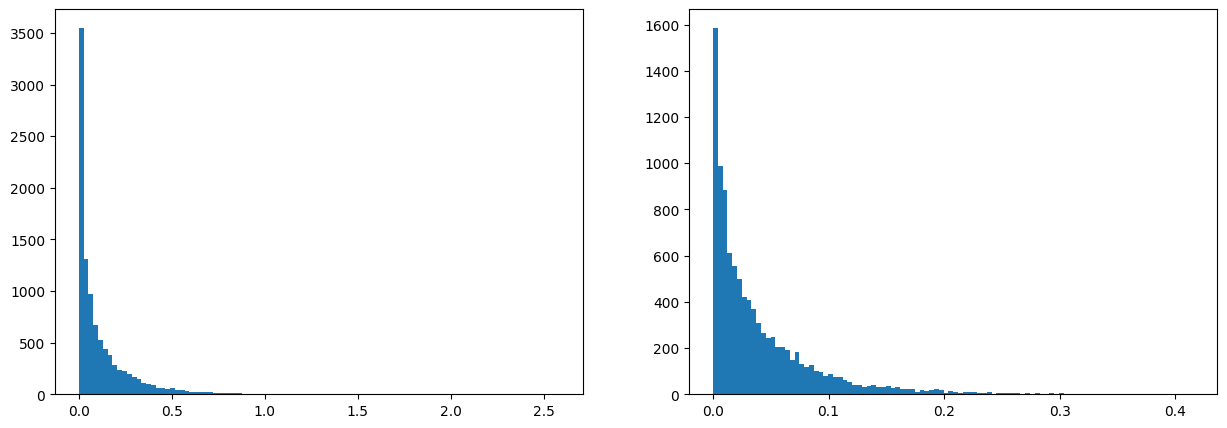

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(l, bins=100)
ax[1].hist(lastV, bins=100)
plt.show()